# Report Coding Notebook

## Comparison of Green Energy Growth and  Energy Prices

Stephen Moilanen, Ryan Eskuri, and Benjamin Schmitt. 

In [212]:
#Load three libraries that are required for compatibility with Excel files and to create visualizations. 
!pip install openpyxl
!pip install xlrd
!pip install altair vega_datasets

### Dependencies

In [213]:
import pandas as pd
import numpy as np
import altair as alt
import json
import openpyxl
import xlrd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from vega_datasets import data


### ChangeLog: 

10-4-22 11:11am [RE]: Added ChangeLog, Added monthly Texas DF, Created Folders for data files 'eia_assets' and 'noaa_assets' 

10-4-22 10:22pm [SBM]: Added numpy to dependencies, deleted empty cells, added text cells describing df's with code cell exploring each df. Added main datasets (stored in folder "MainSetsAllUS"). Created a df for main weather data and 

10-5-22 4:00pm [RE] Added functions to clean and merge state data frames

10-5-22 7:30[SBM] Removed unneeded cells. Added and formatted datasets. Added sections headers. 

10-6-22 11:30[SBM] Formatted datasets and merged production/cost datasets.

10-7-22 11:30[SBM] Merged and edited datasets. Created visualization (rough).

10-8 11:00[RE] Added all state weather data, created function to read and concatenate them before merging with main production/cost  data frame. 

10-8-22 11:30P [SBM] Added DC weather data. Added code checking/investigating NaN values.

10-10-22 12:00PM [SBM] Correct visualization function in section 3. Added visualizations with notations. 

10-11-22 12:30PM [SBM] Added dialog in section 3. Can be used in report and discusses results. 

10-17-22 12:00 [SBM] Cleaned up notebook and added sections from supplementary notebooks. Watermark sent to end of notebook. 

# SECTION 1 - DATA ACQUISITION AND AGGREGATION

### Dataset 1: Weather Data - US Total and Individual States

Included fields are 'Date' (format: YYYYMM), 'temp_F' (temperature in degrees Fahrenheit), 'temp_delta_f' (difference in temperature from annual mean temperature in degrees Fahrenheit), 'prec_in' (precipitation in inches), 'prec_delta_in' (difference in annual mean precipitation in inches), 'PZIndex' (Palmer Z-Index, a unitless value indicating short-term drought conditions),
 and 'PZIndex_delta' (difference in Palmer Z-Index from the annual average). 

The Palmer Drought Z-Index is derived from the Palmer Drought Severity Index, but is intended for use and more accuracy in shorter time periods (e.g. on a monthly basis). It can range from -10 (dry) to +10 (wet) but generally remains within the approximate range of -4 to +4 (Source: https://climatedataguide.ucar.edu/climate-data/palmer-drought-severity-index-pdsi#:~:text=The%20Palmer%20Drought%20Severity%20Index,more%20extreme%20values%20are%20possible.). 

The datasets include an average for the entirety of the contiguous United States - Alaska, Hawaii, and all US territories are not included. Washington DC is included. State-specific data was collected and uploaded later (for all states and DC except for AK and HA. 

The functions below were used to clean the weather datasets into a format that was usable by the team. 

In [214]:
us_temp_df = pd.read_csv('noaa_assets/us/110-tavg-all-1-1990-2022.csv',skiprows=4)
us_pcp_df = pd.read_csv('noaa_assets/us/110-pcp-all-1-1990-2022.csv',skiprows=4)
us_zndx_df = pd.read_csv('noaa_assets/us/110-zndx-all-1-1990-2022.csv',skiprows=3)
#Prep of temp data
def clean_temp_avg(temp_avg_df):
    temp_avg_df['Date'] = pd.to_datetime(temp_avg_df['Date'],format='%Y%m')
    temp_avg_df.rename(columns={'Value': 'Temperature','Anomaly':'Delta from Mean Temp'},inplace=True)

#Prep of precipitation data
def clean_pcp(pcp_df):
    pcp_df['Date'] = pd.to_datetime(pcp_df['Date'],format='%Y%m')
    pcp_df.rename(columns={'Value': 'Precipitation (in)','Anomaly':'Delta from Mean Pcp'},inplace=True)

#Prep of drought data
def clean_zndx(zndx_df):
    zndx_df['Date'] = pd.to_datetime(zndx_df['Date'],format='%Y%m')
    zndx_df.rename(columns={'Value': 'Z-index Drought','Anomaly':'Delta from Mean Z'},inplace=True)

#Merging the seperate sheets into one dataframe
def merge_noaa_dfs(temp_avg_df, pcp_df, zndx_df):
    clean_temp_avg(temp_avg_df)
    clean_pcp(pcp_df)
    clean_zndx(zndx_df)
    merge_df = temp_avg_df.merge(pcp_df, on='Date')
    noaa_df = merge_df.merge(zndx_df, on='Date')
    return noaa_df

Dataframe for the monthly data of the entire US is below, from 1990. 

In [215]:
us_noaa_df = merge_noaa_dfs(us_temp_df,us_pcp_df,us_zndx_df)

us_noaa_df['STATE'] = 'US-TOTAL'

#uncomment below to see output
##us_noaa_df.head()

The cell below collects the filepaths of the weather data for each state for use in later functions. 

In [216]:
def list_files(dir):
    r = []
    states = []
    for root, dirs, files in os.walk(dir):
        #filter only folders with states at the end
        if len(root) > 26:
            #print(len(root))
            states.append(root[-2:])
        for name in files:
            r.append(os.path.join(root, name))
            
    return r, states
path = r'noaa_assets/state_assets'
file_paths, states = list_files(path)

The cell below copies the weather data from Maryland and uses it to describe the data in Washington DC. This is because the NOAA did not provide specific weather data for Washington DC despite the federal district being identified in the electricity generation/consumption data sets. 

Since Washington DC is surrounded by Maryland on three sides, and because it is a relatively small entity in terms of area, it was assumed to have the same weather as the state of Maryland. 

The "states" list was also updated in the cell below to include DC as a variable. The directly in which the DC data was saved was manually created in Deepnote. 

In [217]:
#Create DC weather data by copying Maryland weather data. 
def get_DC():
    DC_file_list = os.listdir("noaa_assets/state_assets/MD")
    print(DC_file_list)
    for item in DC_file_list:
        f = open("noaa_assets/state_assets/DC/" + "DC" + item[2:], "w")
        f.truncate(0)
        existing = open("noaa_assets/state_assets/MD/" + item, "r")
        w = existing.read()
        existing.close()
        #print(type(w))
        f.write(w)
        f.close()
    return None

#The first time this cell was ran, DC had to be added to the states list. 
#This is no longer neccessary as DC is now in the file directory and is...
# ...automatically populated to the states list.

#Uncomment function call below to copy DC data from Maryland.
##get_DC()


In [218]:
#reads 48 states into dict with state names and merged dataframes
def read_merge_noaa(states, file_paths):
    noaa_dfs = {}
    for state in states:
        #print(state)
        noaa_dfs[state] = ''
        for path in file_paths:
            #print(path)
            if state in path:
                #print(state)
                if 'zndx' in path:
                    zndx_df = pd.read_csv(path,skiprows=3)
                elif 'pcp' in path:
                    pcp_df = pd.read_csv(path,skiprows=4)
                else:
                    temp_avg_df = pd.read_csv(path,skiprows=4)
        noaa_df = merge_noaa_dfs(temp_avg_df, pcp_df, zndx_df)
        noaa_df['STATE'] = state
        noaa_dfs[state] = noaa_df
    return noaa_dfs

noaa_dfs = read_merge_noaa(states,file_paths)


In [219]:
#Just a check on the DC data. Uncomment to see. 
##noaa_dfs

### Dataset 2: Energy Price Data - Main Set

The energy price main set includes divisions for specific types of customers. Any field starting with "R_" refers to residential customers, "C_" refers to commercial customers, "I_" refers to industrial customers, "T_" refers to transportation customers, "O_" refers to 'other' customers, while "TOTAL_" refers to all customers. 

Fields ending with "_rev" refer to revenue in thousands of dollars, "_sales" refers to megawatthours sold, "_cust" refers to number of customers, while "_price" refers to cost in cents per kilowatthour.

Data is from the EIA website. Data was lightly manipulated in Excel prior to import (renamed columns, deleted irrelevant rows). 

"Data Status" field refers to whether the data has been finalized or not. Data prior to 2021 has been finalized. 

In [220]:
#Load data and define df
energy_price_df = pd.read_csv("MainSetsAllUS/energy_sales_revenue_customers_cost.csv")

#Looks like there are some nan values.
##print(energy_price_df['Month'].unique())

#Below shows that the spreadsheet footnote was picked up as a row, and all values are nan. Let's get rid of it.
energy_price_df[energy_price_df['Month'].isnull()]
energy_price_df.drop(index = 19889, inplace = True)
#energy_price_df = energy_price_df.astype({'Year':"int"})

#All good now.
#District of Columbia is included (called "DC").
print("Dataset covers years ", energy_price_df['Year'].min(), " to ", energy_price_df['Year'].max(), "\n")

#These lines were used to check if the totals added up. They did. 
##test = energy_price_df[['R_rev', 'C_rev', 'I_rev', 'T_rev', 'O_rev', "TOTAL_rev"]]
##test = test.replace(to_replace = '.', value = 0).astype('float')
##test['tot'] = test[['R_rev', 'C_rev', 'I_rev', 'T_rev', 'O_rev']].sum(axis = 1, skipna = True)
##test[['TOTAL_rev', 'tot']].iloc[0:5]

#Since the totals added up okay, we'll drop the columns we don't need.
#The individual customer types will be removed (so it only shows totals).
#Also, "Data Status" will be removed (we are assuming all data is accurate, even if not finalized).
energy_price_df = energy_price_df[['Year', 'Month', 'State', 'TOTAL_rev', 
                                   'TOTAL_sales', 'TOTAL_cust', 'TOTAL_price']]
print("The following columns were considered unneccesary and were removed:\n", 
        "'Data Status', 'R_rev', 'R_sales', 'R_cust','R_price', 'C_rev', 'C_sales', \n", 
        "'C_cust', 'C_price', 'I_rev', 'I_sales','I_cust', 'I_price', 'T_rev', \n", 
        "'T_sales', 'T_cust', 'T_price', 'O_rev','O_sales', 'O_cust', 'O_price'", '\n')

#Adding a datetime column for merging.
energy_price_df['Day'] = 1
energy_price_df.insert(0, 'Date', pd.to_datetime(energy_price_df[['Year','Month', 'Day']]))
energy_price_df.drop(columns=['Day', 'Year', 'Month'], inplace=True)
print("A datetime column was added and the 'Month'/'Year' columns removed.\n")

#Replace blank values with 0. Change data types to float.
energy_price_df = energy_price_df.replace(to_replace = '.', value = 0)
energy_price_df[['TOTAL_rev', 'TOTAL_sales', 'TOTAL_cust','TOTAL_price']] = energy_price_df[['TOTAL_rev', 'TOTAL_sales', 'TOTAL_cust','TOTAL_price']].astype('float')

#Time to sum to get total US. Will add to same dataset. This will be used later.
#print(energy_price_df.columns)
US_total = energy_price_df[['Date', 'TOTAL_rev', 'TOTAL_sales', 'TOTAL_cust',
       'TOTAL_price']].groupby(['Date'], as_index = False).agg({'TOTAL_rev': "sum", 
                                                                'TOTAL_sales' : "sum", 
                                                                'TOTAL_cust': "sum",
                                                                'TOTAL_price': "mean"})
US_total.insert(1, 'State', value = "US-TOTAL")
energy_price_df = pd.concat([US_total, energy_price_df])

print("Number of States Represented: ", len(energy_price_df['State'].unique()))
print("List of states:\n", energy_price_df['State'].unique(), "\n")
print("Shape of dataframe: ", energy_price_df.shape)
print("Date range: ", energy_price_df.Date.min(), " to ", energy_price_df.Date.max())

#Uncomment below to see dataframe
##energy_price_df

Dataset covers years  1990  to  2022 

The following columns were considered unneccesary and were removed:
 'Data Status', 'R_rev', 'R_sales', 'R_cust','R_price', 'C_rev', 'C_sales', 
 'C_cust', 'C_price', 'I_rev', 'I_sales','I_cust', 'I_price', 'T_rev', 
 'T_sales', 'T_cust', 'T_price', 'O_rev','O_sales', 'O_cust', 'O_price' 

A datetime column was added and the 'Month'/'Year' columns removed.

Number of States Represented:  52
List of states:
 ['US-TOTAL' 'AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI'
 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS'
 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI'
 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY'] 

Shape of dataframe:  (20279, 6)
Date range:  1990-01-01 00:00:00  to  2022-06-01 00:00:00


### Dataset 3: Production Type Data - Monthly from 2001 to 2022

This includes megawatts produced on a monthly basis per state per production type (fossil fuels, solar, wind, etc.). 

Data was downloaded from the EIA website and was provided in spreadsheet format. The defined function below combines all the sheets in the spreadsheet into one. 

The results from running the function below have been saved for convenience (processing time is about a minute). 

In [221]:
def load_production_data_spreadsheets():
    sheet_names = ["2001_2002_FINAL", "2003_2004_FINAL", "2005-2007_FINAL", "2008-2009_FINAL", 
                "2010-2011_FINAL", "2012_Final", "2013_Final", "2014_Final", "2015_Final",
                "2016_Final", "2017_Final","2018_Final", "2019_Final", "2020_Final", 
                "2021_Preliminary", "2022_Preliminary"]

    product_2001_df = pd.read_excel("MainSetsAllUS/8 generation_monthly.xlsx", 
                                    sheet_name = "2001_2002_FINAL", 
                                    header = 0,
                                    index_col = None, 
                                    skiprows = 0,
                                    skipfooter = 0)
    product_2001_df = product_2001_df.rename(columns = {product_2001_df.columns[-1]:"GENERATION (MWh)" })
    #print(product_2001_df.columns)

    print("2001/2002 initialized. Moving to other sheets.")

    for sheet in sheet_names[1:5]:
        print("Appending sheet: ", sheet)
        df_temp = pd.read_excel("MainSetsAllUS/8 generation_monthly.xlsx", 
                                sheet_name = sheet, 
                                header = 0,
                                index_col=None,
                                skiprows = 0,
                                skipfooter = 0)
        df_temp = df_temp.rename(columns = {df_temp.columns[-1]:"GENERATION (MWh)" })
        product_2001_df = pd.concat([product_2001_df, df_temp], axis = 0) # on = ['YEAR', 'MONTH', 'STATE', 'TYPE OF PRODUCER', 'ENERGY SOURCE', 'GENERATION (Megawatthours)'])
    
    print('Switching to new for loop.')
    
    for sheet in sheet_names[5:]:
        print("Appending sheet: ", sheet)
        df_temp = pd.read_excel("MainSetsAllUS/8 generation_monthly.xlsx", 
                                sheet_name = sheet, 
                                header = 0,
                                index_col=None,
                                skiprows = 4,
                                skipfooter = 0)
        df_temp = df_temp.rename(columns = {df_temp.columns[-1]:"GENERATION (MWh)" })
        product_2001_df = pd.concat([product_2001_df, df_temp], axis = 0)
    product_2001_df.reset_index(inplace = True, drop = True)
    return product_2001_df

In [222]:
#This one takes a while to run, so erase the hashtags if it needs to be ran again.
#For convenience, the rendered dataframe was saved in the files. 
#save_production_df_to_csv = load_production_data_spreadsheets()
#save_production_df_to_csv.to_csv("MainSetsAllUS/production_types_df.csv", index = False)

In [223]:
#The csv read-in below was produced from the previous two cells.
#It was saved and is uploaded here for convenience. 
production_types_df = pd.read_csv("MainSetsAllUS/production_types_df.csv")

print("Dataset covers years ", production_types_df['YEAR'].min(), " to ", production_types_df['YEAR'].max(), "\n")

#Adding a datetime column for merging.
production_types_df['Day'] = 1
production_types_df.insert(0, 'Date', pd.to_datetime(production_types_df[['YEAR','MONTH', 'Day']]))
production_types_df.drop(columns=['Day', 'YEAR', 'MONTH'], inplace=True)
print("Min/max datetime: ", production_types_df['Date'].min(), " to ", production_types_df['Date'].max(), "\n")


#Need to fix the two 'US-Total' designations (same value input w/ 2 different formats).
production_types_df['STATE'] = production_types_df["STATE"].replace(to_replace = 'US-Total', value = 'US-TOTAL')
print("Number of States in Dataset: ", len(production_types_df["STATE"].unique()))
print("State in dataset: \n", production_types_df["STATE"].unique(), "\n")

print("Types of Producers included:\n", production_types_df["TYPE OF PRODUCER"].unique(), "\n")

print("We don't need to differentiate between types of producers, so we'll only keep industry total.")
print("Shape of Dataframe prior to removal: ", production_types_df.shape, "\n")
production_types_df = production_types_df[production_types_df['TYPE OF PRODUCER'] == 'Total Electric Power Industry']
production_types_df.drop("TYPE OF PRODUCER", axis = 1, inplace = True)

print("Types of generators included:\n", production_types_df["ENERGY SOURCE"].unique(), "\n")

print("Final shape of Dataframe: ", production_types_df.shape)

#To see dataframe sample, uncomment below.
#production_types_df.sample(10)

Dataset covers years  2001  to  2022 

Min/max datetime:  2001-01-01 00:00:00  to  2022-07-01 00:00:00 

Number of States in Dataset:  52
State in dataset: 
 ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY' 'US-TOTAL'] 

Types of Producers included:
 ['Total Electric Power Industry' 'Electric Generators, Electric Utilities'
 'Combined Heat and Power, Electric Power'
 'Combined Heat and Power, Commercial Power'
 'Combined Heat and Power, Industrial Power'
 'Electric Generators, Independent Power Producers'] 

We don't need to differentiate between types of producers, so we'll only keep industry total.
Shape of Dataframe prior to removal:  (501003, 5) 

Types of generators included:
 ['Coal' 'Petroleum' 'Natural Gas' 'Hydroelectric Conventional' 'Wind'
 'Total' 'Other Gases' 'Nucle

### Dataset 4: Production Type Data - Yearly from 1990 to 2020

This dataset includes similar information as Dataset 3 (production of energy and production source), however is more granular (only organized by year) and goes back to 1990.

The data is truncated at 2001 to prepare it for concatenation with Dataset 4. The monthly average is taken for each year, and then distributed across the 12 months of that year. That allows for monthly estimates between 1990 and 2000, while the years 2001 and 2020 have precise measured estimates. 

In [224]:
#Load data and change one column name (to ensure conformity). 
product_1990_df = pd.read_excel("MainSetsAllUS/annual_generation_state.xls", 
                                #sheet_name = "Net_Generation_1990-2020 Final", 
                                header = 0,
                                index_col = None, 
                                skiprows = 1,
                                skipfooter = 0)
product_1990_df = product_1990_df.rename(columns = {product_1990_df.columns[-1]:"GENERATION (MWh)" })

#Truncate years already included in Dataset 3.
print("Dataset covers years ", product_1990_df['YEAR'].min(), " to ", product_1990_df['YEAR'].max())
print("Will need to delete all dates present in dataset 3 (will concatenate them later).")
product_1990_df = product_1990_df[product_1990_df['YEAR'] < 2001]
print("Dataset NOW covers years ", product_1990_df['YEAR'].min(), " to ", product_1990_df['YEAR'].max(), "\n")



print("Number of States in Dataset: ", len(product_1990_df["STATE"].unique()))
print("State in dataset: \n", product_1990_df["STATE"].unique(), "\n")

print("Types of Producers included:\n", product_1990_df["TYPE OF PRODUCER"].unique(), "\n")

#Remove unneccesary rows (don't need types of producers).
print("We don't need to differentiate between types of producers, so we'll only keep industry total.")
print("Shape of Dataframe prior to removal: ", product_1990_df.shape, "\n")
product_1990_df = product_1990_df[product_1990_df['TYPE OF PRODUCER'] == 'Total Electric Power Industry']
product_1990_df.reset_index(drop = True, inplace = True)
product_1990_df.drop("TYPE OF PRODUCER", axis = 1, inplace = True)

print("Types of generators included:\n", product_1990_df["ENERGY SOURCE"].unique(), "\n")

print("Final shape of Dataframe: ", product_1990_df.shape)

#For dataframe view, uncomment the below.
#product_1990_df.head(10)

Dataset covers years  1990  to  2020
Will need to delete all dates present in dataset 3 (will concatenate them later).
Dataset NOW covers years  1990  to  2000 

Number of States in Dataset:  52
State in dataset: 
 ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'US-TOTAL' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY'] 

Types of Producers included:
 ['Total Electric Power Industry' 'Electric Generators, Electric Utilities'
 'Combined Heat and Power, Industrial Power'
 'Combined Heat and Power, Commercial Power'
 'Electric Generators, Independent Power Producers'
 'Combined Heat and Power, Electric Power'] 

We don't need to differentiate between types of producers, so we'll only keep industry total.
Shape of Dataframe prior to removal:  (17088, 5) 

Types of generators included:
 ['Total' 'Coal' 'Hydroelectric Conventional

The below cell produces a monthly average for production data, since only yearly data was available. It does this by dividing the yearly production by 12 and assigning that quantity to each month. 

In [225]:
#Copy data from prior cell, divide generation by 12 (for each month).
product_1990_monthly = product_1990_df
product_1990_monthly['month_gen'] = product_1990_monthly['GENERATION (MWh)'].apply(lambda x: round(x/12, 3))

#Populate a column with the months, and then explode to get monthly quantity
product_1990_monthly['MONTH'] = None
for i in range(product_1990_monthly.shape[0]):
    product_1990_monthly.at[i, 'MONTH'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
product_1990_monthly = product_1990_monthly.explode('MONTH')

#Adding a datetime column for merging.
product_1990_monthly['Day'] = 1
product_1990_monthly.insert(0, 'Date', pd.to_datetime(product_1990_monthly[['YEAR','MONTH', 'Day']]))
product_1990_monthly.drop(columns=['Day', 'YEAR', 'MONTH'], inplace=True)
print("Min/max datetime: ", product_1990_monthly['Date'].min(), " to ", product_1990_monthly['Date'].max(), "\n")

#Drop column with early data and rename monthly data.
product_1990_monthly.drop(columns = ['GENERATION (MWh)'], inplace = True)
product_1990_monthly.rename(columns = {"month_gen": "GENERATION (MWh)"}, inplace = True)

#Uncomment the below to see sample.
##product_1990_monthly.head(3)

Min/max datetime:  1990-01-01 00:00:00  to  2000-12-01 00:00:00 



# SECTION 2 - Concatenate Datasets

### Concatenate data from 1990 to 2001 and from 2001 to 2022

In [226]:
#print(production_types_df.columns)
#print(product_1990_monthly.columns)

#Create concatenated production dataset.
full_df = pd.concat([production_types_df, product_1990_monthly], axis = 0)
print("Shape of production DF: ", full_df.shape)
print("Date range: ", full_df.Date.min(), " to ", full_df.Date.max())
print("Number of unique states: ", len(full_df.STATE.unique()))
print("List of States: ", full_df.STATE.unique(), "\n")

Shape of production DF:  (194196, 4)
Date range:  1990-01-01 00:00:00  to  2022-07-01 00:00:00
Number of unique states:  52
List of States:  ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY' 'US-TOTAL'] 



### Merge Energy Production Data with Price Data

In [227]:
print(energy_price_df.Date.min(), energy_price_df.Date.max())
energy_price_df.rename(columns = {"State":'STATE'}, inplace = True)
#print(energy_price_df.columns)
#print(energy_price_df.shape)
full_df = full_df.merge(energy_price_df, how = "outer", on = ['Date', 'STATE'])
print("New dataframe shape: ", full_df.shape)

1990-01-01 00:00:00 2022-06-01 00:00:00
New dataframe shape:  (194196, 8)


### Merge Weather Data with Production and Price Data

In [228]:
#extracting noaa state dataframes from dict and concatenating them to us-noaa for merging
weather_dfs = []
for tup in noaa_dfs.items():
    weather_dfs.append(tup)
for state, df in weather_dfs:
    us_noaa_df = pd.concat([df,us_noaa_df])
full_df = full_df.merge(us_noaa_df, on =['Date','STATE'], how ='outer')
print("Shape after merge: ", full_df.shape)
print("Energy source types: ", full_df['ENERGY SOURCE'].unique())

#For sample, uncomment below.
full_df.sample(10)

Shape after merge:  (194196, 14)
Energy source types:  ['Coal' 'Petroleum' 'Natural Gas' 'Hydroelectric Conventional' 'Wind'
 'Total' 'Other Gases' 'Nuclear' 'Wood and Wood Derived Fuels'
 'Other Biomass' 'Other' 'Solar Thermal and Photovoltaic' 'Pumped Storage'
 'Geothermal']


Date STATE                ENERGY SOURCE  GENERATION (MWh)  \
191858 2000-08-01    NH                    Petroleum         39277.333   
141414 1991-12-01    CO                         Coal       2427834.167   
178358 1998-01-01    AZ   Hydroelectric Conventional        914182.417   
139429 1990-09-01    RI                         Coal             0.000   
5620   2002-01-01    HI                    Petroleum        744030.000   
26992  2005-09-01    MN                        Other         26518.000   
44728  2008-09-01    AK                  Natural Gas        311358.000   
55331  2010-05-01    MO                         Coal       6208389.000   
54504  2010-03-01    VT                  Natural Gas           400.000   
25184  2005-05-01    SC  Wood and Wood Derived Fuels        146478.000   

        TOTAL_rev  TOTAL_sales  TOTAL_cust  TOTAL_price  Temperature  \
191858   101241.0     902304.0         0.0        11.22         63.7   
141414   170381.0    2778531.0         0.0         6.13         25.9   
178358   295638.0    4489382.0         0.0         6.59         43.8   
139429    54068.0     554962.0         0.0         9.74         61.9   
5620     101085.0     789490.0         0.0        12.80          NaN   
26992    389010.0    5535009.0         0.0         7.03         61.6   
44728     74150.0     498296.0    319497.0        14.88          NaN   
55331    496097.0    6231450.0   3071751.0         7.96         64.5   
54504     60684.0     459820.0    357723.0        13.20         35.9   
25184    397717.0    6174615.0         0.0         6.44         52.1   

        Delta from Mean Temp  Precipitation (in)  Delta from Mean Pcp  \
191858                  -2.4                3.12                -1.14   
141414                  -0.5                0.82                -0.26   
178358                   0.7                0.55                -0.60   
139429                  -2.1                2.37                -1.76   
5620                     NaN                 NaN                  NaN   
26992                    2.8                4.46                 1.39   
44728                    NaN                 NaN                  NaN   
55331                    0.0                6.77                 1.28   
54504                    7.4                3.94                 0.85   
25184                   -5.4                3.77                 0.26   

        Z-index Drought  Delta from Mean Z  
191858            -0.17              -0.73  
141414             0.04               0.23  
178358            -1.26              -1.08  
139429            -0.97              -1.21  
5620                NaN                NaN  
26992              1.96               1.65  
44728               NaN                NaN  
55331              2.14               1.33  
54504              0.72               0.70  
25184              1.33               1.39

Below, the dataset is explored for Nan values, in which case they are corrected as described. 

In [229]:
#Looking for Nan values and investigating.
test = full_df[full_df.isna().any(axis = 1)]
print("Number of rows with NaN values: ", len(test))
test['STATE'].isna().any()

#The below filter shows that dates after June 2022 are missing data except for generation. 
#This was expected
test[test['Date'] > "2022-06-01 00:00:00"]

test = test[test['Date'] < "2022-07-01 00:00:00"]

#Below shows that Alaska and Hawaii both have NaN data for weather. 
test[test['STATE'].isin(["HI", "AK"])]

#The below shows that a lot of other states don't have weather data past January 2022. 
test = test[~test['STATE'].isin(["HI", "AK"])]

#Below shows that after dropping the rows without weather data past January 2022, no NaN rows remain. 
test.dropna(how = 'any', subset = ["Temperature"])

Number of rows with NaN values:  10133


Empty DataFrame
Columns: [Date, STATE, ENERGY SOURCE, GENERATION (MWh), TOTAL_rev, TOTAL_sales, TOTAL_cust, TOTAL_price, Temperature, Delta from Mean Temp, Precipitation (in), Delta from Mean Pcp, Z-index Drought, Delta from Mean Z]
Index: []

Customer/sales/weather data missing for all jurisdictions after June 2022; for this reason, data after June 2022 is removed in the code block below.

When analyzing the data in the future, the following should be considered:

1. Weather data missing for Alaska and Hawaii on all dates. 

undefined. Weather data missing for all jurisdictions past January 2022.

In [230]:
#Remove all data after June 2022. 
full_df = full_df[full_df["Date"] < "2022-07-01 00:00:00"]

#Uncomment below for samples.
##full_df.sample(10)
##full_df

In [231]:
P_full_df = full_df
P_full_df.to_pickle("eia_assets/P_full_df.pkl")  

# SECTION 3 - Investigation of Energy Production Changes at US Level by decade.

### Summary of insights

The changes in the energy sector in regards to production type and price can be broken into decades. The decade spanning between 1990 and 2000 mainly saw growth in nuclear, natural gas, and coal production. Wind and solar grew at approximate rates of 101% and 34%, but this growth was negligible as a percentage of the total output. Growth in energy costs for consumers per kWh were negligible (around 6%). 

The decade between 2000 and 2010 started to see major changes in the energy sector. Growth in coal generation stagnated, and started to fall in 2008. Wind electric output had the second highest growth by volume, and highest growth by percentage at  approximately %1,500. Most increases in wind energy growth came in the later half of the decade. The highest volume of growth by far was from natural gas (+386,000 GWh), followed by wind (+89,000 GWh) and nuclear (+53,000 GWh). 

Between 2010 and 2021 (11 years total) marked the start of the downfall of coal production, which was cut in half over that time period, dropping about -949,000 GWh. Wind accelerated the volume of output from the previous decade, growing by +285,000 GWh. Increase in solar energy production started to take off as well, particularly around 2015, with growth exceeding 9,360% over the time span. The volumetric growth in solar, while not negligible, was still relatively small compared to other sources, at an increase of +113,000 GWh. Like the previous decade, natural gas production growth was the forerunner with +588,000 GWh, more than twice of wind and more than wind and solar growth together. 

The more recent history of the electric production sector has not necessarily followed a theme of green energy, but rather a theme of pollution reduction. Natural gas, albeit a fossil fuel, burns cleaner than coal and is a relatively economical way to transform coal plants, many of which were built with loans and have not been paid off yet. For this reason, the rise of natural gas boilers in fossil fuel plants overshadows the rise of green energy, particularly wind and solar. To gain more insights, a closer look at jurisdictions that have produced above average green energy production would be helpful. 

Below a function is defined to repetitively explore the data using different parameters. 

In [232]:
#Which sources to include in the output. 
default_production_sources = ['Coal', 'Petroleum', 'Natural Gas', 'Hydroelectric Conventional', 
                              'Wind','Other Gases', 'Nuclear', 'Wood and Wood Derived Fuels',
                              'Other Biomass', 'Other', 'Solar Thermal and Photovoltaic', 
                              'Pumped Storage', 'Geothermal']

#How to aggregate when using groupby. 
aggregate_dict = {'Date': "min", 'GENERATION (MWh)':'sum', 'TOTAL_rev':'sum',
       'TOTAL_sales':'sum', 'TOTAL_cust':'mean', 'TOTAL_price':'mean', 'Temperature':'mean',
       'Delta from Mean Temp':'mean', 'Precipitation (in)':'sum', 'Delta from Mean Pcp':'sum',
       'Z-index Drought':'mean', 'Delta from Mean Z':'mean'}

def compare_generation_and_price(df, 
                                 state = "US-TOTAL", 
                                 sources = default_production_sources, 
                                 include_total_production = False, 
                                 by_year = False,
                                 start_date = '1990-01-01 00:00:00',
                                 end_date = '2022-06-01 00:00:00',
                                 suppress_stats = False
                                 ):
    
    #Add total production. Will require it regardless, and can drop at end if neccesary.
    sources = sources + ["Total"]
    sources = set(sources)

    #Narrow down dataframe into what we need.
    df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    df = df[df["STATE"].isin([state])]
    df = df[df["ENERGY SOURCE"].isin(sources)]

    #Alter dataframe if results are desired by year.
    if by_year == True:
        print("Dataframe was aggregated to yearly quantities (rather than monthly).\n")
        df['Year'] = df["Date"].apply(lambda x: x.year)
        df = df.groupby(["Year", 'STATE', "ENERGY SOURCE"], as_index = False).agg(aggregate_dict).round(3)
        
        #For energy sources, that began in the middle of a year, the average will be thrown off. 
        #For this reason, the averages from the 'Total' energy source column will be used to populate everything.
        df_tot = df[df['ENERGY SOURCE'] == 'Total'].copy()
        df_tot = df_tot[['Year', 'STATE', 'Date', 'TOTAL_rev', 'TOTAL_sales', 'TOTAL_cust', 'TOTAL_price', 
                     'Temperature', 'Delta from Mean Temp', 'Precipitation (in)', 
                     'Delta from Mean Pcp','Z-index Drought', 'Delta from Mean Z']]
        df = df[['Year', 'STATE', 'ENERGY SOURCE', 'GENERATION (MWh)']]
        df = df.merge(df_tot, on = ['Year', 'STATE'], how = 'outer')
    
    #Now we can remove "Totals" from DF if it was indicated in the inputs. 
    if include_total_production == False:
        df = df[df['ENERGY SOURCE'] != "Total"]

    print("Plotting following energy sources: ", list(df["ENERGY SOURCE"].unique()), "\n")
    print("Plotting following states: ", state, "\n")
    print("Dates represented: ", df['Date'].min().date(), " to ", df["Date"].max().date(), '\n')
    print("Range of prices: ", 
          round(df["TOTAL_price"].min(), 2), 
          " to ", 
          round(df["TOTAL_price"].max(), 2), 
          " cents/kWh\n")
    print("Price difference in cents: ", round(df["TOTAL_price"].max() - df["TOTAL_price"].min(), 2))
    #print(df.columns)

    #Create plots. 
    chart1= alt.Chart(df).mark_line(strokeDash=[12, 6]).encode(x= alt.X('Date:T'),
                                                               y= alt.Y('TOTAL_price:Q',
                                                                        scale=alt.Scale(zero=False))
    ).properties(width=500, height=300, title='')

    chart2 = alt.Chart(df).mark_line().encode(
    x='Date:T',
    y=alt.Y('GENERATION (MWh):Q'),
    #removed legend=None from color
    color= alt.Color("ENERGY SOURCE:N",),
    tooltip=['ENERGY SOURCE:N', 'GENERATION (MWh):Q']
    ).properties(width=500, height=300, title='trends in price and generation by source in ' + str(state))

    chart = alt.layer(chart2, chart1).resolve_scale(y = 'independent')

    #Print out some (possibly) helpful stats during exploration of the data. 
    if suppress_stats == False:
        print('STATISTICS')
        start_price = df[df['Date'] == df["Date"].min()]['TOTAL_price'].mean()
        end_price = df[df['Date'] == df["Date"].max()]['TOTAL_price'].mean()
        price_change =  (end_price - start_price)/start_price
        print('Price in', df["Date"].min().year, ": ", start_price)
        print('Price in', df["Date"].max().year, ": ", end_price)
        print("Change in price: ", end_price - start_price)
        print("Percent change in price over span chosen: %", round(price_change*100, 1))
        for source in sources:
            start = df[(df['Date'] == df["Date"].min()) & (df['ENERGY SOURCE'] == source)]['GENERATION (MWh)'].mean()
            end = df[(df['Date'] == df["Date"].max()) & (df['ENERGY SOURCE'] == source)]['GENERATION (MWh)'].mean()
            try:
                change =  (end - start)/start
            except:
                np.nan
            print("Percent change in ", source, " generation over span chosen: %", round(change*100, 1))
            print("MWh change in ", source, " generation over span chosen: ", round((end - start)/1000, 3), " GWh")

    return df, chart

In [233]:
#TEST CELL - Used to explore the data. 
test = compare_generation_and_price(full_df,
                                    state = "US-TOTAL", 
                                    sources = ['Geothermal', 
                                               "Wind", 
                                               'Solar Thermal and Photovoltaic', 
                                               "Coal", 
                                               "Natural Gas", 
                                               "Nuclear",
                                               "Hydroelectric Conventional", 
                                               "Petroleum"], 
                                    include_total_production = True,
                                    by_year = True,
                                    start_date = '2006-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00',
                                    suppress_stats = False)

#Index 0 is the dataframe, index 1 is the plot.
test[0]
#test[1]

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Petroleum', 'Solar Thermal and Photovoltaic', 'Total', 'Wind'] 

Plotting following states:  US-TOTAL 

Dates represented:  2006-01-01  to  2021-01-01 

Range of prices:  8.84  to  11.73  cents/kWh

Price difference in cents:  2.89
STATISTICS
Price in 2006 :  8.838
Price in 2021 :  11.727999999999998
Change in price:  2.889999999999999
Percent change in price over span chosen: % 32.7
Percent change in  Wind  generation over span chosen: % 1328.3
MWh change in  Wind  generation over span chosen:  353178.11  GWh
Percent change in  Coal  generation over span chosen: % -54.9
MWh change in  Coal  generation over span chosen:  -1091832.609  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -10.0
MWh change in  Hydroelectric Conventional  generation over span chosen:  -29021.529

Year     STATE                   ENERGY SOURCE  GENERATION (MWh)  \
0    2006  US-TOTAL                            Coal      1.990511e+09   
1    2006  US-TOTAL                      Geothermal      1.456803e+07   
2    2006  US-TOTAL      Hydroelectric Conventional      2.892464e+08   
3    2006  US-TOTAL                     Natural Gas      8.164408e+08   
4    2006  US-TOTAL                         Nuclear      7.872186e+08   
..    ...       ...                             ...               ...   
139  2021  US-TOTAL                         Nuclear      7.781515e+08   
140  2021  US-TOTAL                       Petroleum      1.878178e+07   
141  2021  US-TOTAL  Solar Thermal and Photovoltaic      1.146782e+08   
142  2021  US-TOTAL                           Total      4.115540e+09   
143  2021  US-TOTAL                            Wind      3.797672e+08   

          Date     TOTAL_rev   TOTAL_sales    TOTAL_cust  TOTAL_price  \
0   2006-01-01  3.265060e+08  3.669919e+09  0.000000e+00        8.838   
1   2006-01-01  3.265060e+08  3.669919e+09  0.000000e+00        8.838   
2   2006-01-01  3.265060e+08  3.669919e+09  0.000000e+00        8.838   
3   2006-01-01  3.265060e+08  3.669919e+09  0.000000e+00        8.838   
4   2006-01-01  3.265060e+08  3.669919e+09  0.000000e+00        8.838   
..         ...           ...           ...           ...          ...   
139 2021-01-01  4.245164e+08  3.793729e+09  1.578651e+08       11.728   
140 2021-01-01  4.245164e+08  3.793729e+09  1.578651e+08       11.728   
141 2021-01-01  4.245164e+08  3.793729e+09  1.578651e+08       11.728   
142 2021-01-01  4.245164e+08  3.793729e+09  1.578651e+08       11.728   
143 2021-01-01  4.245164e+08  3.793729e+09  1.578651e+08       11.728   

     Temperature  Delta from Mean Temp  Precipitation (in)  \
0         54.252                 2.232               29.82   
1         54.252                 2.232               29.82   
2         54.252                 2.232               29.82   
3         54.252                 2.232               29.82   
4         54.252                 2.232               29.82   
..           ...                   ...                 ...   
139       54.504                 2.485               30.47   
140       54.504                 2.485               30.47   
141       54.504                 2.485               30.47   
142       54.504                 2.485               30.47   
143       54.504                 2.485               30.47   

     Delta from Mean Pcp  Z-index Drought  Delta from Mean Z  
0                  -0.12           -0.694             -0.792  
1                  -0.12           -0.694             -0.792  
2                  -0.12           -0.694             -0.792  
3                  -0.12           -0.694             -0.792  
4                  -0.12           -0.694             -0.792  
..                   ...              ...                ...  
139                 0.53           -0.686             -0.783  
140                 0.53           -0.686             -0.783  
141                 0.53           -0.686             -0.783  
142                 0.53           -0.686             -0.783  
143                 0.53           -0.686             -0.783  

[144 rows x 15 columns]

### Insight: Green Energy Didn't Grow Significantly until after 2000, and price of energy stayed between 6.4 and 6.9 cents a kilowatt hour. 

The plot below shows a gradual increase in fossil fuel production along with a modest increase in electricity price in the 90's decade, with little growth in any green energy source. 

In [234]:
#Price vs. Production Source Growth - 1990 to 2000
test = compare_generation_and_price(full_df,
                                    state = "US-TOTAL", 
                                    sources = ['Geothermal', 
                                               "Wind", 
                                               'Solar Thermal and Photovoltaic', 
                                               "Coal", 
                                               "Natural Gas", 
                                               "Nuclear",
                                               "Hydroelectric Conventional", 
                                               "Petroleum"], 
                                    include_total_production = False,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2000-12-01 00:00:00')
test[1]

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Petroleum', 'Solar Thermal and Photovoltaic', 'Wind'] 

Plotting following states:  US-TOTAL 

Dates represented:  1990-01-01  to  2000-01-01 

Range of prices:  6.46  to  6.9  cents/kWh

Price difference in cents:  0.44
STATISTICS
Price in 1990 :  6.460999999999999
Price in 2000 :  6.860999999999999
Change in price:  0.39999999999999947
Percent change in price over span chosen: % 6.2
Percent change in  Wind  generation over span chosen: % 100.6
MWh change in  Wind  generation over span chosen:  2804.661  GWh
Percent change in  Coal  generation over span chosen: % 23.4
MWh change in  Coal  generation over span chosen:  372253.117  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -5.9
MWh change in  Hydroelectric Conventional  generation over span chosen:  -17293.249  GWh

alt.LayerChart(...)

### Insight: Energy prices grew from 7 cents to 10 cents per kWh (approximate) between 2000 and 2010. 

Coal production stayed relatively the same, and was by far the largest producer of electricity. Natural gas production grew significantly, while wind grew gradually. Solar did not see much growth.  

In [235]:
#Price vs. Production Source Growth - 2000 to 2010
test = compare_generation_and_price(full_df,
                                    state = "US-TOTAL", 
                                    sources = ['Geothermal', 
                                               "Wind", 
                                               'Solar Thermal and Photovoltaic', 
                                               "Coal", 
                                               "Natural Gas", 
                                               "Nuclear",
                                               "Hydroelectric Conventional", 
                                               "Petroleum"], 
                                    include_total_production = False,
                                    by_year = True,
                                    start_date = '2000-01-01 00:00:00',
                                    end_date = '2010-12-01 00:00:00')
test[1]

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Petroleum', 'Solar Thermal and Photovoltaic', 'Wind'] 

Plotting following states:  US-TOTAL 

Dates represented:  2000-01-01  to  2010-01-01 

Range of prices:  6.86  to  10.08  cents/kWh

Price difference in cents:  3.22
STATISTICS
Price in 2000 :  6.860999999999999
Price in 2010 :  10.082
Change in price:  3.221000000000002
Percent change in price over span chosen: % 46.9
Percent change in  Wind  generation over span chosen: % 1592.3
MWh change in  Wind  generation over span chosen:  89058.985  GWh
Percent change in  Coal  generation over span chosen: % -6.1
MWh change in  Coal  generation over span chosen:  -118974.318  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -5.6
MWh change in  Hydroelectric Conventional  generation over span chosen:  -15369.529  GWh
Percen

alt.LayerChart(...)

### Insight: The decade between 2010 and 2021 saw a sharp replace of coal by natural gas. Green energy grew modestly. 

The decade of 2010 to 2021 saw a sharp reduction in the use of coal in energy production, and a sharp increase in natural gas, presumably due to the conversion of coal plants into natural gas plants. Green energy, particularly wind and solar, grew at a faster rate than ever before but did not outpace natural gas. 

Energy prices grew a small amount but not nearly as much as the 2000-2010 decade. 

In [236]:
#Price vs. Production Source Growth - 2010 to 2021
test = compare_generation_and_price(full_df,
                                    state = "US-TOTAL", 
                                    sources = ['Geothermal', 
                                               "Wind", 
                                               'Solar Thermal and Photovoltaic', 
                                               "Coal", 
                                               "Natural Gas", 
                                               "Nuclear",
                                               "Hydroelectric Conventional", 
                                               "Petroleum"], 
                                    include_total_production = False,
                                    by_year = True,
                                    start_date = '2010-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00',
                                    suppress_stats = False)
test[1]

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Petroleum', 'Solar Thermal and Photovoltaic', 'Wind'] 

Plotting following states:  US-TOTAL 

Dates represented:  2010-01-01  to  2021-01-01 

Range of prices:  10.08  to  11.73  cents/kWh

Price difference in cents:  1.65
STATISTICS
Price in 2010 :  10.082
Price in 2021 :  11.727999999999998
Change in price:  1.6459999999999972
Percent change in price over span chosen: % 16.3
Percent change in  Wind  generation over span chosen: % 301.2
MWh change in  Wind  generation over span chosen:  285115.002  GWh
Percent change in  Coal  generation over span chosen: % -51.4
MWh change in  Coal  generation over span chosen:  -948611.752  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % 0.0
MWh change in  Hydroelectric Conventional  generation over span chosen:  21.819  GWh
Percent

alt.LayerChart(...)

### Prepare data for report visualization.

Now that exploration occurred at the national level, a decision is made to include a plot in the report, which will be made separately (to be more easily edited and customized). 

Below is a dataframe specifically tailored to show national trends for the team report. 

In [237]:
#First, get a copy of the full_df with all the info we want. 
test = compare_generation_and_price(full_df,
                                    state = "US-TOTAL", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = False,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00',
                                    suppress_stats = True)

#Now, send the data to a csv file so it can be extracted later. 
#df_RG = test[0]
#df_RG.to_csv("df_RG.csv")

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other', 'Other Biomass', 'Other Gases', 'Petroleum', 'Pumped Storage', 'Solar Thermal and Photovoltaic', 'Wind', 'Wood and Wood Derived Fuels'] 

Plotting following states:  US-TOTAL 

Dates represented:  1990-01-01  to  2021-01-01 

Range of prices:  6.46  to  11.73  cents/kWh

Price difference in cents:  5.27


This dataframe ("df_RG) is manipulated in Section 5 to show the above mentioned trends in the team report. 

# SECTION 4 - Analysis of Separate States

Two functions were written below to manipulate/restructure the data in such a way that growth metrics could be calculated for the growth of different energy sources as well as for price.  The first function does the data frame manipulation, while the second automatically extracts the desired trends from the data using print statements. This information is then used to decide which states to visualize more closely, using the function from Section 3. 

### Function for calculating changes in generation and price.

In [238]:
def get_green_energy_increases(df, 
                               start_date = '2000-01-01 00:00:00', 
                               end_date = '2021-12-01 00:00:00', 
                               sources = ['Total',
                                          'Geothermal', 
                                          'Wind', 
                                          'Solar Thermal and Photovoltaic', 
                                          "Coal", 
                                          "Natural Gas", 
                                          "Hydroelectric Conventional"], 
                               states = None, 
                               by_year = True):
    
    #Remove unneccesary columns.
    df = df[['Date', 'STATE', 'ENERGY SOURCE', 'GENERATION (MWh)', 'TOTAL_price']]
    
    #Filter to desired states (if requested)
    if states != None:
        try:
            df = df[df['STATE'].isin(states)]
        except:
            print('Your state selection needs to be a list!')
    else:
        states = list(df['STATE'].unique())

    aggregate_dict = {'Date': "min", 'GENERATION (MWh)':'sum', 'TOTAL_price':'mean'}
    
    #Aggregate by year if desired, narrow df into start/end dates.
    df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    print("Changes in energy production and cost found for following dates: \n", start_date, " to ", end_date)
    if by_year == True:
        print("Dataframe was aggregated to yearly quantities (rather than monthly).\n")
        df['Year'] = df["Date"].apply(lambda x: x.year)
        df = df.groupby(["Year", 'STATE', "ENERGY SOURCE"], as_index = False).agg(aggregate_dict).round(6)
        df = df[(df["Year"] == df["Year"].min()) | (df["Year"] == df["Year"].max())]
        df['Date'] = df['Year']
    else:
        df = df[(df["Date"] == start_date) | (df["Date"] == end_date)]

    #Create totals df to merge later
    df_tot = df[df['ENERGY SOURCE'] == 'Total'].copy()

    #Trim by determined dates and sources:
    df = df[df['ENERGY SOURCE'].isin(sources)]

    #Set up df_tot for merge with df after calculations are made. 
    #Performs calc's for price as well, since it's the same for all energy sources.
    #First, the table is pivoted, and the multiindex column labels renamed and reverted to single index.
    #return df_tot
    df_tot = df_tot.pivot(index = 'STATE', columns = 'Date', values = ['GENERATION (MWh)','TOTAL_price'])
    #return df_tot
    df_tot[['gen_tot_start', 'gen_tot_end', 'price_start', 'price_end']] = df_tot.iloc[:,:]
    df_tot.columns = df_tot.columns.droplevel(1)
    df_tot = df_tot[['gen_tot_start', 'gen_tot_end', 'price_start', 'price_end']]
    #Next, differences are calculated for before/after generation and price. 
    df_tot['MWh_gen_tot_diff'] = round(df_tot['gen_tot_end'] - df_tot['gen_tot_start'], 3)
    df_tot['%_gen_tot_diff'] = round(df_tot['MWh_gen_tot_diff']/df_tot['gen_tot_start'] * 100, 1)
    df_tot['cents_price_growth'] = round(df_tot['price_end'] - df_tot['price_start'], 3)
    df_tot['%price_growth'] = round(df_tot['cents_price_growth']/df_tot['price_start'] * 100, 1)
    #Below just reorders the rows so they are easier to compare, and brings back state as a column.
    df_tot = df_tot[['gen_tot_start', 'gen_tot_end', 'MWh_gen_tot_diff', '%_gen_tot_diff', 
              'price_start', 'price_end','cents_price_growth','%price_growth']].reset_index()
    #print(df_tot.columns)
    #return df_tot

    #Now calculate averages for the seperate energy sources
    #Price is included in the df_tot dataframe, so we'll leave that out.
    #First, pivot the before/after dates and rename the columns.  
    df = df[['STATE', 'ENERGY SOURCE', 'Date', 'GENERATION (MWh)', 'TOTAL_price']]
    df = df.pivot(index = ['STATE', 'ENERGY SOURCE'], columns = 'Date', values = 'GENERATION (MWh)')
    
    df[['St_GENERATION (MWh)', 'End_GENERATION (MWh)']] = df.iloc[:,:]
    df = df[['St_GENERATION (MWh)', 'End_GENERATION (MWh)']].reset_index().fillna(0)
    #Next, calculate changes.
    df['MWh_gen_growth'] = round(df['End_GENERATION (MWh)'] - df['St_GENERATION (MWh)'], 3)
    df['%gen_growth'] = round(df['MWh_gen_growth']/df['St_GENERATION (MWh)'] * 100, 1)
    
    #Merge df_tot with df to compare individual sources with total generated. 
    df = df.merge(df_tot, on = 'STATE', how = 'outer')

    #Make new comparisons with totals.
    #First, the growth as a percent of the total growth. 
        #Can be a negative number (many states reduced production).
    df['gen_%_of_tot_growth'] = round(((df['MWh_gen_growth']) / df['MWh_gen_tot_diff']) * 100, 1)
    #Percent of total production for end date. Used to gauge largest users at that point. 
    df['end_%_of_total'] = round((df['End_GENERATION (MWh)'] / df['gen_tot_end']) * 100, 1)

    #Reorder the columns so they are easier to compare.
    df = df[['STATE', 'ENERGY SOURCE', 'St_GENERATION (MWh)', 'End_GENERATION (MWh)',
       'MWh_gen_growth', '%gen_growth', 'gen_%_of_tot_growth', 'end_%_of_total', 'gen_tot_start', 'gen_tot_end',
       'MWh_gen_tot_diff', '%_gen_tot_diff', 'price_start', 'price_end',
       'cents_price_growth', '%price_growth']]

    #print(df.columns)
    return df

#For an example, uncomment the line below. 
##get_green_energy_increases(full_df, start_date = '2006-01-01 00:00:00')


Now we have the changes by percent as well as by MWh for energy. The change as a percent of the total change in generation was also calculated. The data frame also lists the changes of price by cents and percentage change over the designated timeframe. 

Next, the function that prints out the top/bottom states for different metrics is produced below.

### Function to print out top/bottom states for different metrics of generation and price changes. 

In [239]:
#The function below prints out statistics from the dataframe produced in the previous cell. 
def get_growth_stats(df, n = 5, energy_sources = None):
    
    print("Note: Percent changes from 0 are not included.")

    if energy_sources == None:
        sources = list(df['ENERGY SOURCE'].unique())
    else:
        try:
            df = df[df['ENERGY SOURCE'].isin(energy_sources)]
            sources = list(df['ENERGY SOURCE'].unique())
        except:
            print('WARNING: There was a problem with the energy_sources variable - df columns used instead.\n\n')
            sources = list(df['ENERGY SOURCE'].unique())
        

        sources = list(df['ENERGY SOURCE'].unique())

    states = list(df['STATE'].unique())
    print("STATS\n")

    temp = df[["STATE", 'cents_price_growth', "%price_growth"]].groupby(by = "STATE", as_index = False).mean()
    #print(temp.columns)
    temp = temp.sort_values(by='cents_price_growth', ascending = False)
    print("States with highest price inceases by cents: ", list(temp['STATE'].iloc[0:n]))
    temp = temp.sort_values(by='cents_price_growth', ascending = True)
    print("States with lowest price inceases by cents: ", list(temp['STATE'].iloc[0:n]))
    temp = temp.sort_values(by='%price_growth', ascending = False)
    print("States with highest price inceases by percent: ", list(temp['STATE'].iloc[0:n]))
    temp = temp.sort_values(by='%price_growth', ascending = True)
    print("States with lowest price inceases by percent: ", list(temp['STATE'].iloc[0:n]), "\n")

    temp = df[df['ENERGY SOURCE'] == 'Total'].sort_values(by = 'MWh_gen_tot_diff', ascending = False)
    print("States with highest growth of electricity production: ", list(temp['STATE'].iloc[0:n]))
    temp = df[(df['MWh_gen_tot_diff'] < 0) & (df['ENERGY SOURCE'] == 'Total')]
    print("States with loss of (negative) production: \n", list(temp['STATE'].iloc[0:]), "\n")

    #Prints stats for different types of production (wind, solar, coal, etc.)
    for source in sources:
        print(source.upper())
        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = 'end_%_of_total', ascending = False)
        print("Largest users of source as percentage of total production at designated end date: ", 
              list(temp['STATE'].iloc[0:n]))
        print("Percentage of total, respectively: ", list(temp['end_%_of_total'].iloc[0:n]), "\n")
        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = 'MWh_gen_growth', ascending = False)
        print("Top states for growth by MWh: ", list(temp['STATE'].iloc[0:n]))
        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = '%gen_growth', ascending = False)
        print("Top states for growth by %: ", list(temp['STATE'].iloc[0:n]))
        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = 'gen_%_of_tot_growth', ascending = False)
        print("Top states for growth as a portion of total growth: ", list(temp['STATE'].iloc[0:n]))

        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = 'MWh_gen_growth', ascending = True)
        print("Worst states for growth by MWh: ", list(temp['STATE'].iloc[0:n]))
        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = '%gen_growth', ascending = True)
        print("Worst states for growth by %: ", list(temp['STATE'].iloc[0:n]))
        temp = df[df['ENERGY SOURCE'] == source].sort_values(by = 'gen_%_of_tot_growth', ascending = True)
        print("Worst states for growth as a portion of total growth: ", list(temp['STATE'].iloc[0:n]))
        
        
        print("\n")
    
    return None


### Use of above functions

Below the different metrics can be changed to explore the data, and see leading/lagging states for different time periods and energy sources. 

In [240]:
#Create desired dataframe with first function.
t = get_green_energy_increases(full_df, 
                               start_date = '2006-01-01 00:00:00',
                               #end_date = '2021-12-01 00:00:00', 
                               by_year = True)

#List out the states with the highest and lowest growth rates. 
source_list = ['Total', 'Geothermal', "Wind", 'Solar Thermal and Photovoltaic', "Coal", "Natural Gas"]
get_growth_stats(t, 
                 n = 10, #Number of states to return
                 energy_sources = source_list)

Changes in energy production and cost found for following dates: 
 2006-01-01 00:00:00  to  2021-12-01 00:00:00
Dataframe was aggregated to yearly quantities (rather than monthly).

Note: Percent changes from 0 are not included.
STATS

States with highest price inceases by cents:  ['HI', 'AK', 'CA', 'VT', 'MI', 'RI', 'MN', 'CT', 'IN', 'WV']
States with lowest price inceases by cents:  ['NV', 'TX', 'FL', 'DE', 'LA', 'NY', 'PA', 'MS', 'OK', 'MD']
States with highest price inceases by percent:  ['WV', 'KY', 'ID', 'IN', 'MN', 'MI', 'MO', 'WY', 'SD', 'AK']
States with lowest price inceases by percent:  ['NV', 'TX', 'FL', 'DE', 'LA', 'NY', 'PA', 'MS', 'MD', 'DC'] 

States with highest growth of electricity production:  ['TX', 'US-TOTAL', 'PA', 'MS', 'VA', 'FL', 'IA', 'ND', 'KS', 'SD']
States with loss of (negative) production: 
 ['AK', 'CA', 'DE', 'GA', 'HI', 'IL', 'IN', 'KY', 'MA', 'MD', 'ME', 'MO', 'MT', 'NH', 'NM', 'NY', 'OH', 'TN', 'VT', 'WV', 'WY'] 

COAL
Largest users of source as perc

## Plotting individual states

From the functions above, several states were chosen to explore individually. The summaries of each are below. 

### Texas

Texas was chosen to be plotted because it had the second lowest price increase (between 2005 and 2015), but the highest increase of wind by MWh and second highest increase of solar (by MHw). 

A big price drop (per kWh) occurred between 2008 and 2012, but nothing on the plot seems to correlate with the drop, meaning it was likely due to other causes (fossil fuel prices, politics and/or regulation, for example). 

The 15 years shown has a general decrease in coal production balances by increases in natural gas and wind. Wind had the highest growth, outpacing even the total growth of production in the state. Wind nowadays accounts for about 20% of total production.

In [241]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "TX", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = False,
                                    by_year = True,
                                    start_date = '2005-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00', 
                                    suppress_stats = False)
test[1]

#Uncomment below to save new df for report visualization
##test[0].to_csv('Stephens_visualizations/df_TX')

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other', 'Other Biomass', 'Other Gases', 'Petroleum', 'Wind', 'Wood and Wood Derived Fuels', 'Solar Thermal and Photovoltaic'] 

Plotting following states:  TX 

Dates represented:  2005-01-01  to  2021-01-01 

Range of prices:  8.34  to  10.91  cents/kWh

Price difference in cents:  2.57
STATISTICS
Price in 2005 :  9.062
Price in 2021 :  9.400000000000002
Change in price:  0.33800000000000274
Percent change in price over span chosen: % 3.7
Percent change in  Wind  generation over span chosen: % 2261.2
MWh change in  Wind  generation over span chosen:  95812.07  GWh
Percent change in  Coal  generation over span chosen: % -40.2
MWh change in  Coal  generation over span chosen:  -59576.427  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -16.2
MWh change in  Hydroelectric Conventional  

alt.LayerChart(...)

### Nevada

Nevada was chosen to be plotted because it has the lowest price increases (between 2005 and 2021) and installed the largest proportion of geothermal energy. It also ranked highly for solar growth and solar production as percentage of total for 2021.

A series of unsteady drops in price started in 2009, paralleled by more steady growth in natural gas and geothermal. Solar started to grow especially around 2011. As with the typical national trend, coal dropped with growth in natural gas and renewables, especially solar. 

In [242]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "NV", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = True,
                                    by_year = True,
                                    start_date = '2010-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00',
                                    suppress_stats = False)
test[1]

#print("Percentage of 2021 production that is solar in NV: ", 6648356.0/41880183.0)


Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Other', 'Other Gases', 'Petroleum', 'Solar Thermal and Photovoltaic', 'Total', 'Wood and Wood Derived Fuels', 'Other Biomass', 'Wind'] 

Plotting following states:  NV 

Dates represented:  2010-01-01  to  2021-01-01 

Range of prices:  8.24  to  9.61  cents/kWh

Price difference in cents:  1.37
STATISTICS
Price in 2010 :  9.607
Price in 2021 :  8.528000000000002
Change in price:  -1.078999999999997
Percent change in price over span chosen: % -11.2
Percent change in  Wind  generation over span chosen: % nan
MWh change in  Wind  generation over span chosen:  nan  GWh
Percent change in  Coal  generation over span chosen: % -60.7
MWh change in  Coal  generation over span chosen:  -4244.828  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -9.5
MWh change in  Hydroelectric Conventional

alt.LayerChart(...)

### California

Interestingly, California was one of the worst ranked states for growth in wind and solar (as a percentage and as a portion of the total, for years 2005 to 2021). It also ranked highly on price increases (third in terms of increase in cents/kWh). It is rated at the #1 state for using solar as a percentage of the total energy produced, however, for the year 2021. It was for these reasons California was plotted. 

Upon plotting and closer looks at the data, it's clear that California's poor ranking for solar resulted from most states not being ranked in the first place (most states didn't have solar generation in 2005, so their ranking was 0). The same was true with wind, albeit a lower proportion of states were not ranked. Total generation in California actually dropped between the given years, resulting in a negative quantity for the percent of total growth. 

Prices increased gradually with no significant peaks/troughs in the plot, going up about 8 cents over the 15 years (around a 70% increase). Natural gas production see-sawed while the only consistent growth came from wind and solar, suggesting that price is correlated with green energy production. 

In [243]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "CA", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = False,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00')
test[1]
#Uncomment below to save new df for report visualization
##test[0].to_csv('Stephens_visualizations/df_CA')

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other', 'Other Biomass', 'Other Gases', 'Petroleum', 'Pumped Storage', 'Solar Thermal and Photovoltaic', 'Wind', 'Wood and Wood Derived Fuels'] 

Plotting following states:  CA 

Dates represented:  1990-01-01  to  2021-01-01 

Range of prices:  8.81  to  19.62  cents/kWh

Price difference in cents:  10.81
STATISTICS
Price in 1990 :  8.809
Price in 2021 :  19.618
Change in price:  10.809
Percent change in price over span chosen: % 122.7
Percent change in  Wind  generation over span chosen: % 466.4
MWh change in  Wind  generation over span chosen:  12866.63  GWh
Percent change in  Coal  generation over span chosen: % -88.8
MWh change in  Coal  generation over span chosen:  -2343.522  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -38.8
MWh change in  Hydroelectric Conve

alt.LayerChart(...)

### Iowa

Iowa was choses to be plotted due to it's propensity of wind energy production growth. In fact, nowadays wind accounts for over half of it's energy production. 

The plot of Iowa seems to show a correlation between wind energy production growth and growth in electricity rates. Wind was largely responsible for replacing coal in the state over the past 15 years. Solar production is negligible. 

In [244]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "IA", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = True,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00')
test[1]
#Uncomment below to save new df for report visualization
##test[0].to_csv('Stephens_visualizations/df_IA')

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other Biomass', 'Petroleum', 'Total', 'Wind', 'Wood and Wood Derived Fuels', 'Other', 'Solar Thermal and Photovoltaic'] 

Plotting following states:  IA 

Dates represented:  1990-01-01  to  2021-01-01 

Range of prices:  5.9  to  9.12  cents/kWh

Price difference in cents:  3.22
STATISTICS
Price in 1990 :  5.906
Price in 2021 :  9.117000000000003
Change in price:  3.211000000000003
Percent change in price over span chosen: % 54.4
Percent change in  Wind  generation over span chosen: % nan
MWh change in  Wind  generation over span chosen:  nan  GWh
Percent change in  Coal  generation over span chosen: % -14.1
MWh change in  Coal  generation over span chosen:  -3630.925  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % 9.2
MWh change in  Hydroelectric Conventional  generation over span

alt.LayerChart(...)

### South Dakota

Although South Dakota didn't rank in the top five for any of wind's growth metrics between 2005 and 2021, in 2021 it still had 52% of it's energy production produced by wind, second only to Iowa (which is at 55%). For this reason it was chosed to be plotted. 

The plot shows that wind growth in South Dakota really took off in 2019, more than doubling output of that particular resource, but also saw a gradual trend since the start of the period in 2005. Cost did likewise, suggesting a correlation. Like it other parts of the country, natural gas use increased as coal usage decreased. It can be seen that total energy output has greatly increased over the the five years between 2017 and 2021 - a whopping 60% or so. It is likely that much of this new energy is exported outside South Dakota. 

In [245]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "SD", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = True,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00')
test[1]
#Uncomment below to save new df for report visualization
##test[0].to_csv('Stephens_visualizations/df_SD')

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Hydroelectric Conventional', 'Natural Gas', 'Petroleum', 'Total', 'Wind', 'Other', 'Other Biomass', 'Solar Thermal and Photovoltaic', 'Wood and Wood Derived Fuels'] 

Plotting following states:  SD 

Dates represented:  1990-01-01  to  2021-01-01 

Range of prices:  6.13  to  10.46  cents/kWh

Price difference in cents:  4.33
STATISTICS
Price in 1990 :  6.131
Price in 2021 :  10.459000000000001
Change in price:  4.328000000000001
Percent change in price over span chosen: % 70.6
Percent change in  Wind  generation over span chosen: % nan
MWh change in  Wind  generation over span chosen:  nan  GWh
Percent change in  Coal  generation over span chosen: % -33.7
MWh change in  Coal  generation over span chosen:  -834.125  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % 34.6
MWh change in  Hydroelectric Conventional  generation over span chosen:

alt.LayerChart(...)

### New York

New York was chosen because it's a large state and may provide some additional insight. 

In [246]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "NY", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = True,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00')
test[1]
#Uncomment below to save new df for report visualization
##test[0].to_csv('Stephens_visualizations/df_NY')

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other Biomass', 'Other Gases', 'Petroleum', 'Pumped Storage', 'Total', 'Wood and Wood Derived Fuels', 'Wind', 'Other', 'Solar Thermal and Photovoltaic'] 

Plotting following states:  NY 

Dates represented:  1990-01-01  to  2021-01-01 

Range of prices:  9.36  to  16.38  cents/kWh

Price difference in cents:  7.02
STATISTICS
Price in 1990 :  9.363
Price in 2021 :  16.199999999999996
Change in price:  6.836999999999996
Percent change in price over span chosen: % 73.0
Percent change in  Wind  generation over span chosen: % nan
MWh change in  Wind  generation over span chosen:  nan  GWh
Percent change in  Coal  generation over span chosen: % -100.0
MWh change in  Coal  generation over span chosen:  -25913.047  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % -0.8
MWh change in  Hydroelec

alt.LayerChart(...)

### Florida

Florida was chosen because it's a large state and may provide some additional insight. 

In [247]:
#Looking at total growth in entire US, along with some others. 
test = compare_generation_and_price(full_df,
                                    state = "FL", 
                                    sources = ['Coal', 'Petroleum', 'Natural Gas', 
                                               'Hydroelectric Conventional', 'Wind', 
                                               'Other Gases', 'Nuclear', 
                                               'Wood and Wood Derived Fuels', 'Other Biomass', 
                                               'Other', 'Solar Thermal and Photovoltaic', 
                                               'Pumped Storage', 'Geothermal'], 
                                    include_total_production = True,
                                    by_year = True,
                                    start_date = '1990-01-01 00:00:00',
                                    end_date = '2021-12-01 00:00:00')
test[1]
#Uncomment below to save new df for report visualization
##test[0].to_csv('Stephens_visualizations/df_FL')

Dataframe was aggregated to yearly quantities (rather than monthly).

Plotting following energy sources:  ['Coal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Other', 'Other Biomass', 'Petroleum', 'Total', 'Wood and Wood Derived Fuels', 'Other Gases', 'Solar Thermal and Photovoltaic'] 

Plotting following states:  FL 

Dates represented:  1990-01-01  to  2021-01-01 

Range of prices:  6.86  to  11.5  cents/kWh

Price difference in cents:  4.64
STATISTICS
Price in 1990 :  7.033
Price in 2021 :  10.75
Change in price:  3.7169999999999996
Percent change in price over span chosen: % 52.9
Percent change in  Wind  generation over span chosen: % nan
MWh change in  Wind  generation over span chosen:  nan  GWh
Percent change in  Coal  generation over span chosen: % -69.4
MWh change in  Coal  generation over span chosen:  -41717.106  GWh
Percent change in  Hydroelectric Conventional  generation over span chosen: % 26.5
MWh change in  Hydroelectric Conventional  generation over span 

alt.LayerChart(...)

# SECTION 5 - Report Visualizations

Below are visualizations for pages 5 and 6 in the report. 

### Visualization for US Level Energy Overview

In [248]:
#Read in dataframe that was defined in Section 3
df_RG = pd.read_csv('Stephens_visualizations/df_RG.csv')
print("Year Range: ", df_RG['Year'].min(), " to ", df_RG['Year'].max())
#print('Energy Sources: ', list(df_RG['ENERGY SOURCE']))
df_RG = df_RG[['Year', 'ENERGY SOURCE', 'GENERATION (MWh)', "TOTAL_price"]]

Year Range:  1990  to  2021


In [249]:
#Dictate which energy sources to plot, and which to include as "other".
#sub-df 'df_RGa' is the dataframe for 'other' production, to be concatenated later.
df_RGa = df_RG[df_RG['ENERGY SOURCE'].isin(['Petroleum', 'Hydroelectric Conventional',
                                            'Other Gases', 'Nuclear', 'Wood and Wood Derived Fuels', 
                                            'Other Biomass', 'Other', 'Pumped Storage', 'Geothermal'])]

df_RGa = df_RGa.groupby(by="Year", as_index = False).agg({'GENERATION (MWh)': 'sum', 
                                                          'TOTAL_price': 'max'})

df_RGa['ENERGY SOURCE'] = "Other"
##df_RGa

In [250]:
#Separate coal, natural gas, wind, and solar. 
df_RG = df_RG[~df_RG['ENERGY SOURCE'].isin(['Petroleum', 'Hydroelectric Conventional',
                                            'Other Gases', 'Nuclear', 'Wood and Wood Derived Fuels', 
                                            'Other Biomass', 'Other', 'Pumped Storage', 'Geothermal'])]

#Add 'other' production back into the df to plot. Change some names for the plotting. 
df = pd.concat([df_RG, df_RGa])
df['ENERGY SOURCE'].unique()
df = df.sort_values('Year').reset_index(drop = True)
df['GENERATION (MWh)'], df['TOTAL_price'] = round(df['GENERATION (MWh)'], 0), round(df['TOTAL_price'], 2)
df['Year'] = pd.to_datetime(df['Year'], format = '%Y')
df['legend_anno'] = "Price (cents/kWh)"
df['ENERGY SOURCE'] = df['ENERGY SOURCE'].where(df['ENERGY SOURCE'] != 'Solar Thermal and Photovoltaic', 'Solar')
df['GENERATION (MWh)'] = df['GENERATION (MWh)'] / 1000000
df.rename(columns = {'ENERGY SOURCE': 'Source', 
                     'GENERATION (MWh)': 'Generation (Terawatt-hours)', 
                     'TOTAL_price': 'Price (Cents per Kilowatt-hour)'}, 
          inplace = True)

#del df_RG
#del df_RGa

In [251]:
chart1= alt.Chart(df
    ).mark_line(strokeDash=[12, 6], color = 'black'
    ).encode(x= alt.X('Year:T', 
                      axis = alt.Axis(labelFontSize = 12,
                      titleFontSize = 12)),
             y= alt.Y('Price (Cents per Kilowatt-hour):Q',scale=alt.Scale(zero=False),
                      axis = alt.Axis(labelFontSize = 12,
                      titleFontSize = 12)),
             opacity = alt.Opacity('legend_anno:N',
                                         scale = alt.Scale(domain = ['Price (cents/kWh'], range = [(12, 6)]),
                                         legend = alt.Legend(title = "Price", 
                                                             values = [''],
                                                             symbolDash = [3, 3]
                                                             #labelExpr = {'Price (cents/kWh)': "hi"}
                                                            )
                                        )
    ).properties(width=400, height=270, title='')

chart2 = alt.Chart(df).mark_line().encode(
    x='Year:T',
    y=alt.Y('Generation (Terawatt-hours):Q',
            axis = alt.Axis(labelFontSize = 12,
                      titleFontSize = 12)),
    #removed legend=None from color
    color= alt.Color("Source:N",),
    tooltip=['Source:N', 'Generation (Terawatt-hours):Q']
    ).properties(width=400, height=270, title='Trends in US Electricity Production')

chart = alt.layer(chart2, chart1).resolve_scale(y = 'independent')

chart

alt.LayerChart(...)

Above is the chart used in the report page 5. 

### State Trends

Next, plots for the report showing trends in individual states were created. Functions were created for this since the task was repetitive. One function for the dataframe manipulation, and one for the plotting. 

The files to read in were saved in Section 4.

In [252]:
def manipulate_state(path, to_group = ['Petroleum', 'Hydroelectric Conventional',
                                        'Other Gases', 'Nuclear', 'Wood and Wood Derived Fuels', 
                                        'Other Biomass', 'Other', 'Pumped Storage', 'Geothermal']):
    df_RG = pd.read_csv(path)
    #print("Year Range: ", df_RG['Year'].min(), " to ", df_RG['Year'].max())
    print("Data is for the State of", df_RG['STATE'].iloc[0])
    #print('Energy Sources: ', list(df_RG['ENERGY SOURCE']))
    df_RG = df_RG[['Year', 'ENERGY SOURCE', 'GENERATION (MWh)', "TOTAL_price"]]

    #Seperate groups to include in "other" production. 
    df_RGa = df_RG[df_RG['ENERGY SOURCE'].isin(to_group)]
    df_RGa = df_RGa.groupby(by="Year", as_index = False).agg({'GENERATION (MWh)': 'sum', 
                                                              'TOTAL_price': 'max'})
    df_RGa['ENERGY SOURCE'] = "Other"

    #Separate coal, natural gas, wind, and solar. 
    df_RG = df_RG[~df_RG['ENERGY SOURCE'].isin(to_group)]

    #Combine the two back together. 
    df = pd.concat([df_RG, df_RGa])
    df['ENERGY SOURCE'].unique()
    df = df.sort_values('Year').reset_index(drop = True)
    df['GENERATION (MWh)'], df['TOTAL_price'] = round(df['GENERATION (MWh)'], 0), round(df['TOTAL_price'], 2)
    df['Year'] = pd.to_datetime(df['Year'], format = '%Y')
    df['legend_anno'] = "Price (cents/kWh)"
    df['ENERGY SOURCE'] = df['ENERGY SOURCE'].where(df['ENERGY SOURCE'] != 'Solar Thermal and Photovoltaic', 'Solar')
    df['GENERATION (MWh)'] = df['GENERATION (MWh)'] / 1000000
    df.rename(columns = {'ENERGY SOURCE': 'Source', 
                         'GENERATION (MWh)': 'Generation (Terawatt-hours)', 
                         'TOTAL_price': 'Price (Cents per Kilowatt-hour)'}, 
              inplace = True)

    return (df)

Next is the function for the plot. This keeps the characteristics of all the plots consistent. 

In [253]:
def get_state_viz(df, state = "needs_state_name", min_year = None):
    
    #Truncates plot at specific year, if desired.
    if min_year != None:
        try:
            df = df[df['Year'] >= min_year]
        except:
            print("Dude, you need to enter a correct year in string form: 'YYYY'")

    chart1= alt.Chart(df
        ).mark_line(strokeDash=[12, 6], color = 'black'
        ).encode(x= alt.X('Year:T', 
                        axis = alt.Axis(title = None, labelFontSize = 12,
                        titleFontSize = 12)),
                y= alt.Y('Price (Cents per Kilowatt-hour):Q',scale=alt.Scale(zero=False),
                        axis = alt.Axis(labelFontSize = 12,
                        titleFontSize = 12, title = "Price (cents/KWh)")),
                opacity = alt.Opacity('legend_anno:N',
                                            scale = alt.Scale(domain = ['Price (cents/kWh'], range = [(12, 6)]),
                                            #legend = None,
                                            legend = alt.Legend(#title = "Price",
                                                                title = '',
                                                                labelFontSize = 12, 
                                                                #values = [''],
                                                                values = ['Price'],
                                                                symbolDash = [3, 3]
                                                                #labelExpr = {'Price (cents/kWh)': "hi"}
                                                                )
                                            )
        ).properties(width=270, height=150, title='')

    chart2 = alt.Chart(df).mark_line().encode(
        x='Year:T',
        y=alt.Y('Generation (Terawatt-hours):Q',
                axis = alt.Axis(labelFontSize = 12,
                        titleFontSize = 12, title = "Generation (TWh)")),
        #removed legend=None from color
        color= alt.Color("Source:N",
                         scale = alt.Scale(domain = ["Coal", "Natural Gas", "Other", "Solar", "Wind", "Geothermal"], 
                                           range = ['#1f77b4', '#ff7f0e', '#d62728', '#6baed6', '#31a354', "#a55194"]), 
                         #legend = None,
                         legend = alt.Legend(title = ['KEY'],
                                             titleFontSize = 12,
                                             labelFontSize = 12, 
                                             values = ["Coal", "Natural Gas", "Other", "Solar", "Wind", "Geothermal"])
                         ),
        tooltip=['Source:N', 'Generation (Terawatt-hours):Q']
        ).properties(width=270, height=150, title=state)

    chart = alt.layer(chart2, chart1).resolve_scale(y = 'independent')

    return chart

Next, the desired states were plotted and the images saved for the report. 

In some cases, the function was altered slightly to accommodate a specific need of a visualization.

In [254]:
get_state_viz(manipulate_state('Stephens_visualizations/df_TX'), state = 'Texas', min_year = '2005')

Data is for the State of TX


alt.LayerChart(...)

In [255]:
get_state_viz(manipulate_state('Stephens_visualizations/df_CA',
                                to_group = ['Petroleum', 'Hydroelectric Conventional',
                                        'Other Gases', 'Nuclear', 'Wood and Wood Derived Fuels', 
                                        'Other Biomass', 'Other', 'Pumped Storage']), 
                                        state = 'California', min_year = '2005')

Data is for the State of CA


alt.LayerChart(...)

In [256]:
get_state_viz(manipulate_state('Stephens_visualizations/df_NV', 
                               to_group = ['Petroleum', 'Hydroelectric Conventional',
                                        'Other Gases', 'Nuclear', 'Wood and Wood Derived Fuels', 
                                        'Other Biomass', 'Other', 'Pumped Storage']), 
                               state = 'Nevada', min_year = '2005')

Data is for the State of NV


alt.LayerChart(...)

In [257]:
get_state_viz(manipulate_state('Stephens_visualizations/df_IA'), state = 'Iowa', min_year = '2005')

Data is for the State of IA


alt.LayerChart(...)

# SECTION 6 - Relationship between temperature, electricity generation by source, and electricity price. 

The following functions and visualizations explore the relationship between green energy use, electricity price, and temperature. Several line charts are used to depict price and temperature over time. Several functions are used to rank states by solar and wind generation.  A bar chart is used to compare price in states with the highest and lowest wind and solar generation.  A scatter plot is used to depict the relationship between price and temperature in individual states. There are also choropleth maps that depict the differences in green energy use, electricity price, and temperature across the United States.

## Summary of insights

There is a strong seasonal relationship between temperature and total electricity generation. Electricity generation starts to increase in the spring and typically peaks in July or August. This is not surprising because July and August have the highest average temperatures and the use of air conditioning equipment increases with increasing temperature. Electricity generation then decreases with temperature until late fall when it levels off.

There is also a strong seasonal relationship between temperature and price of electricity. Price of electricity starts to increase in the spring and typically peaks in July or August. We didn’t have demand data in our data set but we can make some inferences about demand from generation. We can assume that increased generation is a result of increased demand. So, the observed price increases might be the utilities response to increased demand. Changing price in response to demand is a technique that is frequently used by utilities to reduce peak demand. Accommodating large fluctuations in demand can be expensive for a utility because they either need to increase production or by excess power from another source.

We can observe different relationships between price and temperature in different states. In some states, like Iowa, price increases are more pronounced as temperature increases. While in other states, like Kentucky, price is not as strongly correlated with temperature. This difference in the price and temperature relationship could be related to green energy use.

We picked Iowa and Kentucky for comparison because, in 2021, Iowa had the highest average wind and solar electricity generation as percent of total generation and Kentucky had the lowest. In 2021 the five states with the highest average wind and solar electricity generation as percent of total generation, in descending order, were: Iowa, South Dakota, Kansas, Oklahoma, and New Mexico. In 2021 the five states with the lowest average wind and solar electricity generation as percent of total generation, in descending order, were: Kentucky, Louisiana, Alabama, Tennessee, and Mississippi.


### line charts

In [258]:
#This function produces a chart showing the relationship between monthly average temperature and monthly average electricity generation over 
#time in the United States. 
def trends_in_gen_us():
    #this disables the 5000 row max
    alt.data_transformers.disable_max_rows()
    #this filters the df for us total
    source = full_df
    source =  source[source['ENERGY SOURCE'] == 'Total']
    source = source[source['Date'].dt.year > 2000]
    source = source[source['STATE'] == 'US-TOTAL']

    chart1 = alt.Chart(source).mark_line().encode(
    x = alt.X('Date'),
    y = alt.Y('GENERATION (MWh)', title='Generation (MWh)'),
    #color = alt.Color('STATE:N', legend=None),
    tooltip='Date'
    ).properties(width=600, height=400, title='' )

    chart2 = alt.Chart(source).mark_line(opacity=.5).encode(
    x = alt.X('Date', title=None),
    y = alt.Y('Temperature', title='Temperature (F)'),
    #color = alt.Color('STATE:N', legend=None),
    tooltip='Date'
    ).properties(width=600, height=400, title='Seasonal Trends In Electricity Generation and Average Temperature in the US' )

    trend_chart = alt.layer(chart1, chart2).resolve_scale(y = 'independent')
    return trend_chart

trends_in_gen_us()

alt.LayerChart(...)

As you can see, the seasonal correlation between temperature and electricity generation is quite strong.

In [259]:
#This function produces a chart showing the relationship between monthly average temperature and monthly average electricity price over 
#time in the United States. 
def trends_in_price_us():
    #this disables the 5000 row max
    alt.data_transformers.disable_max_rows()
    #this filters the df for us total
    source = full_df
    source = source[source['STATE'] == 'US-TOTAL']

    chart1 = alt.Chart(source).mark_line().encode(
    x = alt.X('Date'),
    y = alt.Y('TOTAL_price', title='Price in cents'),
    tooltip='Date'
    ).properties(width=600, height=400, title='' )

    chart2 = alt.Chart(source).mark_line(opacity=.5).encode(
    x = alt.X('Date', title=None),
    y = alt.Y('Temperature', title='Temperature (F)'),
    tooltip='Date'
    ).properties(width=600, height=400, title='Seasonal Trends In Electricity Price and Average Temperature in the US' )

    trend_chart = alt.layer(chart1, chart2).resolve_scale(y = 'independent')
    return trend_chart

trends_in_price_us()

alt.LayerChart(...)

As you can see in the chart above, the seasonal correlation between temperature and electricity price is quite strong. The correlation is much more pronounced from spring to fall.

In [260]:
#This function produces a chart showing the relationship between monthly average temperature and monthly average 
#electricity price over time in a single state. 
def trends_in_price_state(state):
    #this disables the 5000 row max
    alt.data_transformers.disable_max_rows()

    source = full_df
    source = source[source['STATE'] == state]

    chart1 = alt.Chart(source).mark_line().encode(
    x = alt.X('Date'),
    y = alt.Y('TOTAL_price', title='Price in cents'),
    #color = alt.Color('STATE:N', legend=None),
    tooltip='Date'
    ).properties(width=600, height=400, title='' )

    chart2 = alt.Chart(source).mark_line(opacity=.5).encode(
    x = alt.X('Date', title=None),
    y = alt.Y('Temperature', title='Temperature (F)'),
    #color = alt.Color('STATE:N', legend=None),
    tooltip='Date'
    ).properties(width=600, height=400, title='Seasonal Trends In Electricity Price and Average Temperature in '+state )

    trend_state_chart = alt.layer(chart1, chart2).resolve_scale(y = 'independent')
    return trend_state_chart
    
trends_in_price_state('IA')

alt.LayerChart(...)

In [261]:
trends_in_price_state('KY')

alt.LayerChart(...)

As you can see in the two previous charts, the seasonal correlation between temperature and electricity price is much higher in Iowa as compared to Kentucky.

### ranking functions

In [262]:
#This function produces a new df that includes a column for each select green energy sources as percent of total generation. 
#It also adds a column with a state code that is used in producing altair choropleth maps later in the notebook.
def source_rank():
    df_rank = full_df[['Date', 'STATE', 'TOTAL_price', 'Temperature', 'ENERGY SOURCE', 'GENERATION (MWh)']]
    
    df_rank = pd.pivot(df_rank, index=['Date', 'STATE', 'TOTAL_price', 'Temperature'], columns=['ENERGY SOURCE'],values= ['GENERATION (MWh)'])
    df_rank.reset_index(inplace=True)
    df_rank = df_rank.droplevel(0, axis=1)
    df_rank['Date'] = df_rank.iloc[:,0] 
    df_rank['STATE'] = df_rank.iloc[:,1] 
    df_rank['TOTAL_price'] = df_rank.iloc[:,2]
    df_rank['Temperature'] = df_rank.iloc[:,3]
    df_rank = df_rank.iloc[:,4:]
    #print(df_rank.head())
    
    #Need to add a % wind and solar column
    df_rank.fillna(value=0, inplace=True) # the calc will not work with NaN values
    df_rank['wind and solar as % of total'] = (df_rank['Solar Thermal and Photovoltaic']+ df_rank['Wind'])/df_rank['Total']
    df_rank['solar as % of total'] = df_rank['Solar Thermal and Photovoltaic']/df_rank['Total']
    df_rank['wind as % of total'] = df_rank['Wind']/df_rank['Total']
    #print(df_rank.head())

    #Adding state code for maping
    state_code ={1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 
    11: 'DC', 12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA',
    20: 'KS', 21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN',
    28: 'MS', 29: 'MO', 30: 'MT', 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 
    35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK', 41: 'OR', 
    42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN', 48: 'TX',
    49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI', 56: 'WY'}

    state_id = dict(zip(state_code.values(), state_code.keys()))

    df_rank['id'] = df_rank['STATE'].map(state_id)
    #print(df_rank.columns)
    #print(df_rank.head())

    return df_rank

df_rank = source_rank()
#source_rank()

In [263]:
#This function produces a list of states ordered by their generation of wind and solar as percent of total generation.
def get_state_ranks(year):
    #filter by year
    ranked = df_rank[df_rank['Date'].dt.year == year] 
    #group by state and get mean
    #ranked = ranked.groupby('STATE').sum().reset_index()
    ranked = ranked.groupby('STATE').mean().reset_index()
    #get wind and solar list
    ranked_w_s = ranked.sort_values(by='wind and solar as % of total', ascending=False)
    print('States ranked by average wind and solar generation as % of total:')
    print(ranked_w_s['STATE'].tolist())
    #get list
    ranked_w_s = ranked.sort_values(by='wind as % of total', ascending=False)
    print('States ranked by average wind generation as % of total:')
    print(ranked_w_s['STATE'].tolist())
    #get solar list
    ranked_s = ranked.sort_values(by='solar as % of total', ascending=False)
    print('States ranked by average solar generation as % of total:')
    print(ranked_s['STATE'].tolist())
    return None
get_state_ranks(2021)

States ranked by average wind and solar generation as % of total:
['IA', 'SD', 'KS', 'OK', 'NM', 'ND', 'CO', 'NE', 'MN', 'CA', 'ME', 'VT', 'TX', 'WY', 'ID', 'OR', 'NV', 'HI', 'US-TOTAL', 'DC', 'MT', 'MA', 'IL', 'UT', 'IN', 'MO', 'WA', 'NC', 'AZ', 'MI', 'RI', 'NY', 'GA', 'FL', 'VA', 'WI', 'NH', 'MD', 'WV', 'OH', 'NJ', 'SC', 'AK', 'DE', 'PA', 'AR', 'CT', 'MS', 'TN', 'AL', 'LA', 'KY']
States ranked by average wind generation as % of total:
['IA', 'SD', 'KS', 'OK', 'ND', 'NM', 'CO', 'NE', 'ME', 'MN', 'TX', 'WY', 'ID', 'OR', 'VT', 'MT', 'IL', 'US-TOTAL', 'WA', 'IN', 'MO', 'CA', 'HI', 'MI', 'NY', 'NH', 'WV', 'WI', 'RI', 'AK', 'OH', 'UT', 'AZ', 'PA', 'MD', 'MA', 'NV', 'NC', 'DE', 'VA', 'TN', 'NJ', 'CT', 'GA', 'LA', 'AR', 'KY', 'FL', 'SC', 'AL', 'DC', 'MS']
States ranked by average solar generation as % of total:
['CA', 'NV', 'DC', 'MA', 'VT', 'UT', 'NC', 'AZ', 'HI', 'NM', 'RI', 'GA', 'FL', 'VA', 'ID', 'MN', 'CO', 'TX', 'US-TOTAL', 'OR', 'NJ', 'SC', 'DE', 'MD', 'ME', 'NY', 'AR', 'IN', 'CT', 'M

### bar chart

In [264]:
#This function produces a bar chart comparing price of electricity and wind and solar generation in select states.
def high_low_bar():
    #the following are 2021 ranking of wind and solar use
    #high_states = ['IA', 'SD', 'KS', 'OK','NM']
    # ---------------
    #low_states = ['KY', 'LA', 'AL', 'TN', 'MS']
    #----------------
    both= ['IA', 'SD', 'KS', 'OK','NM', 'MS', 'TN', 'AL', 'LA', 'KY' ]
 
    source = df_rank
    source = source[source['Date'].dt.year == 2021]
    source = source.groupby('STATE').mean().reset_index()
    #return source
    source = source[source['STATE'].isin(both)]
    
    w_s_bar = alt.Chart(source).mark_bar(color='green', opacity=0.5, width=10).encode(
    alt.X('STATE:N', sort=both),
    alt.Y('wind and solar as % of total', title='Wind and solar generation as % of total (in green)'),
    #alt.Color('STATE:N'), #legend=None),
    ).properties(width=600, height=300, 
             title='')

    price_bar = alt.Chart(source).mark_bar(opacity=0.5).encode(
    alt.X('STATE:N', sort=both),
    alt.Y('TOTAL_price:Q', title='Price in cents (in blue)'), #scale=alt.Scale(zero=False)),
    #alt.Color('STATE:N'), #legend=None),
    ).properties(width=600, height=300, 
             title='Average Price of Electricity in States with Highest and Lowest Wind and Solar Generation in 2021')
    
    h_l_bar = alt.layer(price_bar, w_s_bar).resolve_scale(y = 'independent')

    return h_l_bar
    
high_low_bar()

alt.LayerChart(...)

As you can see in the bar chart above, average electricity price is not that different in states that get a large portion of their electricity from wind and solar as compared to states that do not get much electricity from wind and solar sources.

### scatter plot

In [275]:
#This function produces a scatter plot depicting the relationship between electricity price and temperature for select states and years.
#The lines represent linear regression lines using OLS.
full_df = pd.read_pickle("eia_assets/P_full_df.pkl")


def high_low_scatter():

    source = full_df
    #return full_df
    source = source[source['Date'].dt.year > 2015]
    

    source = source[source['Date'].dt.year < 2022]
    #return source
    #Looking at a subset of months to see cold to warmest
    #source = source[source['Date'].dt.month < 9]

    ky_p_vs_t = alt.Chart(source[source['STATE']== 'KY']).mark_circle(color='orange').encode(
    x = alt.X('Temperature', title='Temperature (F)'),
    y = alt.Y('TOTAL_price', scale=alt.Scale(zero=False), title='Total price in cents'),
    #color = alt.Color('STATE:N'),
    tooltip=['STATE', 'Date']
    ).properties(width=600, height=400, title='' )

    #ky_p_vs_t
    ky_chart = ky_p_vs_t + ky_p_vs_t.transform_regression('Temperature', 'TOTAL_price').mark_line(color='orange', opacity=0.5)

    ia_p_vs_t = alt.Chart(source[source['STATE']== 'IA']).mark_circle(color='green').encode(
    x = alt.X('Temperature'),
    y = alt.Y('TOTAL_price', scale=alt.Scale(zero=False)),
    #color = alt.Color('STATE:N', legend=None),
    tooltip=['STATE', 'Date']
    ).properties(width=600, height=400, 
    title='Relationship Between Price and Temperature for IA (in green) and KY (in orange) With Regression Lines' )

    #ia_p_vs_t
    ia_chart = ia_p_vs_t + ia_p_vs_t.transform_regression('Temperature', 'TOTAL_price').mark_line(color='green', opacity=0.5)

    h_l_scat = ky_chart + ia_chart

    return h_l_scat

    
high_low_scatter()

alt.LayerChart(...)

In the scatter plot above, you can see that the price of electricity in Iowa gets higher as temperature increases. However, in Kentucky the price of electricity does not increase much with increasing temperature.

### maps

In [266]:
#This function produces a choropleth map depicting average wind and solar generation as percent of total generation.
def wind_solar_map():
    states = alt.topo_feature(data.us_10m.url, 'states')

    source=df_rank
    source = source[source['Date'].dt.year == 2021]
    source = source.groupby('STATE').mean()

    base_s = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

    wind_solar_map = alt.Chart(states).mark_geoshape().encode(
    color='wind and solar as % of total:Q'
    ).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['wind and solar as % of total'])
    ).project(
    type='albersUsa'
    ).properties(
    width=500,
    height=300
    )

    ws_map = (base_s + wind_solar_map).properties(title='Average Wind and Solar Generation as Proportion of Total in 2021')
    return ws_map
    
wind_solar_map()

alt.LayerChart(...)

In [267]:
#This function produces a choropleth map depicting average price of electricity.
def price_map():
    states = alt.topo_feature(data.us_10m.url, 'states')

    source=df_rank
    source = source[source['Date'].dt.year == 2021]
    source = source.groupby('STATE').mean()
    
    base_s = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

    price_map = alt.Chart(states).mark_geoshape().encode(
    color='TOTAL_price:Q'
    ).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['TOTAL_price'])
    ).project(
    type='albersUsa'
    ).properties(
    width=500,
    height=300
    )

    p_map = (base_s + price_map).properties(title='Average Price of Electricity in 2021')
    return p_map

price_map()

alt.LayerChart(...)

In [268]:
#This function produces a choropleth map depicting average temperature.
def temp_map():

    states = alt.topo_feature(data.us_10m.url, 'states')

    source=df_rank
    source = source[source['Date'].dt.year == 2021]
    source = source.groupby('STATE').mean()


    base_s = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

    temp_map = alt.Chart(states).mark_geoshape().encode(
    color='Temperature:Q'
    ).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['Temperature'])
    ).project(
    type='albersUsa'
    ).properties(
    width=500,
    height=300
    )

    t_map = (base_s + temp_map).properties(title='Average Temperature (F) in 2021')
    return t_map

temp_map()

alt.LayerChart(...)

In [269]:
#This function produces a choropleth map depicting average solar generation as percent of total generation.
def solar_map():

    states = alt.topo_feature(data.us_10m.url, 'states')

    source=df_rank
    source = source[source['Date'].dt.year == 2021]
    source = source.groupby('STATE').mean()
    

    base_s = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

    solar_map = alt.Chart(states).mark_geoshape().encode(
    color='solar as % of total:Q'
    ).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['solar as % of total'])
    ).project(
    type='albersUsa'
    ).properties(
    width=500,
    height=300
    )
    solar = (base_s + solar_map).properties(title='Average Solar Generation As Proportion Of Total Generation In 2021')
    return solar
    
solar_map()

alt.LayerChart(...)

In [270]:
#Adding state code dict for maping
state_code ={1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 
    11: 'DC', 12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA',
    20: 'KS', 21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN',
    28: 'MS', 29: 'MO', 30: 'MT', 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 
    35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK', 41: 'OR', 
    42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN', 48: 'TX',
    49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI', 56: 'WY'}

state_id = dict(zip(state_code.values(), state_code.keys()))

In [271]:
#This function produces a choropleth map depicting standard deviation in electricity price over a year.
def price_std_map():

    states = alt.topo_feature(data.us_10m.url, 'states')

    source=df_rank
    source = source[source['Date'].dt.year == 2021]
    source = source.groupby('STATE').std().reset_index()
    source.drop(columns='id', inplace=True)
    source['id'] = source['STATE'].map(state_id)
    
    base_s = alt.Chart(states).mark_geoshape(fill='white', stroke='black', strokeWidth=0.5)

    price_std_map = alt.Chart(states).mark_geoshape().encode(
    color='TOTAL_price:Q'
    ).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['TOTAL_price'])
    ).project(
    type='albersUsa'
    ).properties(
    width=500,
    height=300,
    title='Standard Deviation in Electricity Price in 2021'
    )
    price_std = base_s + price_std_map
    return price_std
    
price_std_map()

alt.LayerChart(...)

The map above shows an interesting similarity to the map of average wind and solar generation. Maybe states that generate lots of wind and solar also adjust their electricity prices more? That could be a  strategy to control demand when the generation source, wind or solar, can’t be ramped up to meet increased demand.

### test plot

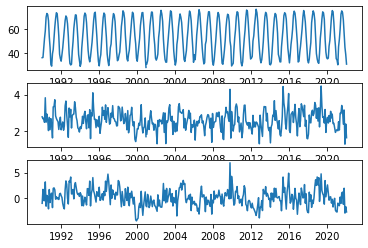

In [272]:
#test cell to try plotting in matplotlib
us_total_df = full_df[full_df['STATE']=='US-TOTAL']

plt.subplot(311)
plt.plot(us_total_df['Date'],us_total_df['Temperature'])

plt.subplot(312)
plt.plot(us_total_df['Date'],us_total_df['Precipitation (in)'])

plt.subplot(313)
plt.plot(us_total_df['Date'],us_total_df['Z-index Drought'])


# Section 7 - Viz function to generate sales to drought comparisons

C:\Users\sbmoi\AppData\Local\Temp\ipykernel_18844\3971617950.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


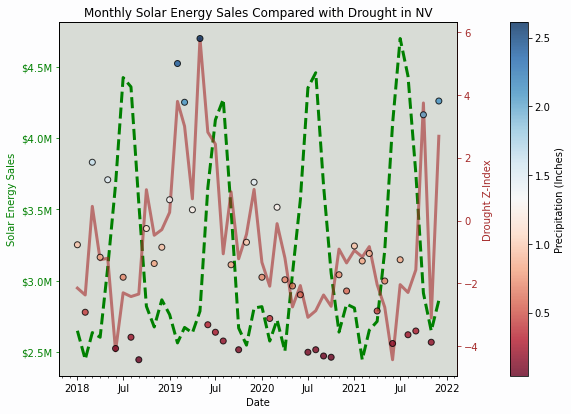

In [273]:

#helper function from matplotlib that handles large numbers in axes labels
def currency(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s
#pass in a single state and multiple years in a list to adjust the function as you want
#
def chart_weather_renew(df,states=['NV'],years=['2010','2011'],energy=['Solar Thermal and Photovoltaic']):
    #logic to take years parameter and get all months in those years from dataframe plotted
    dates = [pd.date_range(start=year,periods=12,freq='MS'
        ).strftime("%Y-%m-%d %H:%M:%S").tolist() for year in years]
    d_mask = []
    for year in dates:
        for month in year:
            d_mask.append(month)
        
    df = df[df['Date'].isin(d_mask)]
    df = df[df['STATE'].isin(states)]
    df = df[df['ENERGY SOURCE'].isin(energy)]
    #setting up axes and plotting data
    fig, ax = plt.subplots()
    fig.set_size_inches(9.5, 6.5)
    twin1 = ax.twinx()
    twin2 = ax.twinx()
    ax.plot('Date', 'TOTAL_sales',color='green',linestyle = 'dashed',linewidth = 3,data=df)
    twin1.plot('Date','Z-index Drought'
                ,color = 'brown',alpha = 0.6,linewidth = 3,data=df)
    pcm = twin2.scatter('Date','Precipitation (in)',c='Precipitation (in)'
                ,cmap='RdBu',alpha = 0.8,edgecolors='black',data=df)
    
    #labels
    ax.set_title('Monthly Solar Energy Sales Compared with Drought in {}'.format(states[0]))
    ax.set_xlabel('Date')
    ax.set_ylabel('Solar Energy Sales')
    ax.yaxis.set_major_formatter(currency)
    twin1.set_ylabel('Drought Z-Index')

    #colors
    ax.set_facecolor('xkcd:light grey')
    fig.patch.set_facecolor('xkcd:pale grey')
    ax.tick_params(axis='y',colors='green')
    ax.yaxis.label.set_color('green')
    twin1.tick_params(axis='y', colors='brown')
    twin1.spines['right'].set_color('brown')
    twin1.yaxis.label.set_color('brown')
    
    fig.colorbar(pcm,cmap='RdBu',ax=twin2,pad=0.1,label='Precipitation (Inches)')
    twin2.get_yaxis().set_visible(False)
    #tick labels
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    #changes small ticks to only include some shortended month names (depends on # of years)
    ax.xaxis.set_minor_locator(months)
    #changes x-axis labels to display clean year
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    return fig.show()
#ca_chart = chart_weather_renew(full_df,states=['CA'],years=['2018','2019','2020','2021'])
nv_chart = chart_weather_renew(full_df,states=['NV'],years=['2018','2019','2020','2021'])

#plt.savefig('nv_plot.png')

# Dependencies

In [274]:
#Adds version history
!pip install watermark
%load_ext watermark
%watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-10-17T19:41:34.752569-04:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 2, GenuineIntel
CPU cores   : 8
Architecture: 64bit

numpy     : 1.21.5
openpyxl  : 3.0.9
json      : 2.0.9
matplotlib: 3.5.1
xlrd      : 2.0.1
pandas    : 1.4.2
altair    : 4.2.0



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=630e24e7-366e-45e6-b4c1-fa741c7078af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>